In [1]:
!nvidia-smi

Sat Feb  3 18:40:18 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.24       Driver Version: 528.24       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
|  0%   36C    P8    15W / 320W |   2997MiB / 16376MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler

module_path='/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Cohort_selection/'
if module_path not in sys.path:
    sys.path.append(module_path)

from cohort_loader import *

module_path='/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/supervised_contrastive_learning/FT-Transformer'
if module_path not in sys.path:
    sys.path.append(module_path)

from model import *
from pytorch_metric_learning import losses
import torch.optim as optim

c:\Users\DAHS\anaconda3\envs\DL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
mimic_data_dir = '/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Cohort_selection/MIMIC-IV-COHORT.csv.gz'
eicu_data_dir = '/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Cohort_selection/eICU-COHORT.csv.gz'

In [4]:
## Build Dataset 
print(f'Build Dataset ....')

dataset_train = TableDataset(data_path=mimic_data_dir, data_type='mimic',mode='train',seed=9040)
# loader_train = DataLoader(dataset_train, batch_size=128, shuffle=True, drop_last=True)

y_train_indices = dataset_train.df_num.index
y_train = [dataset_train.y[i] for i in y_train_indices]
class_sample_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])

weight = 1. / class_sample_count
    
samples_weight = np.array([weight[t-1] for t in y_train])
samples_weight = torch.from_numpy(samples_weight)
sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

loader_train = DataLoader(dataset_train, batch_size=128, shuffle=False, sampler=sampler, drop_last=True)

dataset_val = TableDataset(data_path=mimic_data_dir, data_type='mimic',mode='valid',seed=9040)

y_valid_indices = dataset_val.df_num.index
y_valid = [dataset_val.y[i] for i in y_valid_indices]
class_sample_count = np.array([len(np.where(y_valid == t)[0]) for t in np.unique(y_valid)])

weight = 1. / class_sample_count
    
samples_weight = np.array([weight[t-1] for t in y_valid])
samples_weight = torch.from_numpy(samples_weight)
sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

loader_val = DataLoader(dataset_val, batch_size=128, shuffle=False, sampler=sampler, drop_last=True)

# Tuple Containing the number of unique values within each category
card_categories = []
for col in dataset_train.df_cat.columns:
    card_categories.append(dataset_train.df_cat[col].nunique())

Build Dataset ....
========== 데이터셋 분할 정보 ==========
데이터셋 비율: 학습 = 0.70, 테스트 = 0.30
학습셋 클래스 비율: classes
1    387626
2     11118
3     13863
4      3838
Name: count, dtype: int64
테스트셋 클래스 비율: classes
1    157229
2      4903
3      6157
4      1666
Name: count, dtype: int64
--------------------------------------
========== 클래스 비율 ==========
학습셋 클래스 비율: 0.93:0.03:0.03:0.01
테스트셋 클래스 비율: 0.93:0.03:0.04:0.01
--------------------------------------
========== 환자 및 체류 정보 ==========
학습셋 환자 수: 6820
테스트셋 환자 수: 2923
학습셋 체류 수: 7096
테스트셋 체류 수: 3050
--------------------------------------
========== 실험 설정 ==========
분할 시드: 9040
학습 비율: 0.7
임계값: 0.05
--------------------------------------
========== 실행 결과 ==========
총 소요 시간(초): 0.40
시도한 시행 횟수: 0
========== 데이터셋 분할 정보 ==========
데이터셋 비율: 학습 = 0.70, 테스트 = 0.30
학습셋 클래스 비율: classes
1    387626
2     11118
3     13863
4      3838
Name: count, dtype: int64
테스트셋 클래스 비율: classes
1    157229
2      4903
3      6157
4      1666
Name: count, dtype: int64
-----------

In [5]:
# for inference
# eicu_train = TableDataset(data_path=eicu_data_dir, data_type='eicu',mode='valid',seed=9040)
# loader_eicu_out = DataLoader(eicu_train, batch_size=32, shuffle=False, drop_last=False)

# mimic_train = TableDataset(data_path=mimic_data_dir, data_type='mimic',mode='train',seed=9040)
# loader_trn_out = DataLoader(mimic_train, batch_size=32, shuffle=False, drop_last=False)

# mimic_valid = TableDataset(data_path=mimic_data_dir, data_type='mimic',mode='valid',seed=9040)
# loader_val_out = DataLoader(mimic_valid, batch_size=32, shuffle=False, drop_last=False)

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

SEED = 5723
seed_everything(seed = SEED)

In [6]:
import math
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [7]:
import gc
gc.collect()
import optuna
from optuna.trial import TrialState

path_model = "./checkpoint"
if not os.path.exists(path_model):
    os.makedirs(os.path.join(path_model))

def param():
    categories = card_categories
    num_continuous = 158 
    dim = 78                       # Embedding Dimension of Input Data  32
    depth = 3                      # Nums of Attention Layer Depth  6
    heads = 4                      # Nums of Attention head
    dim_head = 49                 # Dimension of Attention(Q,K,V)
    attn_dropout = 0.4585             # Ratio of Attention Layer dropout
    ff_dropout = 0.4210  # Ratio of FeedForward Layer dropout
    temp = 0.1082 
    total_epoch = 45
    lr =  4.57188135223033e-05
    num_special_tokens = 2
    return categories, num_continuous, dim, depth, heads, dim_head, attn_dropout, ff_dropout, temp, total_epoch, lr, num_special_tokens 


def train(trial, search = False):
    global emb_model, optimizer, train_loss_history  # train_loss_history 추가
    # device            = torch.device('cuda:0')
    train_loss_history = []  # Epoch별 평균 train loss 저장을 위한 리스트 초기화
    patience = 8
    early_stop_counter = 0
    categories, num_continuous, dim, depth, heads, dim_head, attn_dropout, ff_dropout, temp, total_epoch, lr, num_special_tokens = param()
    log_file = "training_log_FTT_optuna.txt" 
        
    def log_message(message):
        with open(log_file, "a") as file:
            file.write(message + "\n")
        print(message)
    
    
    # search parameters
    if search == True:
        lr = trial.suggest_uniform('lr', 0.000009, 0.0001)
        dim      = trial.suggest_int('emb dim', 60,100)
        dim_head      = trial.suggest_int('Dimension of Attention(Q,K,V)', 30,100)
        heads = trial.suggest_int('head', 2,8)
        depth      = trial.suggest_int('depth', 2,4)
        ff_dropout = trial.suggest_uniform('FeedForward Layer dropout', 0.3, 0.65)
        temp       = trial.suggest_uniform('temp', 0.05, 0.5)
        
    log_message(f'learning_rate : {lr}, \nepoch :  {total_epoch}, Embedding Dimension of Input Data : {dim}, Dimension of Attention : {dim_head}, Attention Head : {heads}, Nums of Attention Layer Depth : {depth} drop_rate : {ff_dropout:.4f} temperature : {temp:.4f}')
    
    # 모델 정의
    emb_model = FTTransformer(categories=categories,
    num_continuous=num_continuous,
    dim=dim,
    depth=depth,
    heads=heads,
    dim_head=dim_head,
    num_special_tokens = 2,
    attn_dropout=attn_dropout,
    ff_dropout=ff_dropout).to(device)
    
    # print(emb_model)

    contrastive_loss = losses.SupConLoss(temperature=temp)
    # optimizer = optim.RMSprop(emb_model.parameters(), lr= lr)
    optimizer = optim.AdamW(emb_model.parameters(), lr = lr)
    # scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=15, T_mult=1, eta_max=0.01,  T_up=10, gamma=0.6)
    
    ## Model Train and Eval
    Best_valid_loss = 1e9
    for epoch in range(1, total_epoch+1):
        emb_model.train()
        running_loss = 0

        # current_lr = optimizer.param_groups[0]["lr"]
        
        for num_iter, batch_data in enumerate(tqdm(loader_train)):
            optimizer.zero_grad()
            
            X_num, X_cat, label = batch_data
            X_num, X_cat, label = X_num.to(device), X_cat.to(device), label.to(device)

            latent, _ = emb_model(X_cat,X_num,True)
            label =  label.type(torch.LongTensor)
            
            # backward pass
            loss = contrastive_loss(latent, label)
            # loss = criterion(output, label.unsqueeze(dim = 1))
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            # scheduler.step()  
            
        avg_train_loss = running_loss / len(loader_train)
        train_loss_history.append(avg_train_loss)  # 평균 train loss 저장
        log_message(f'Epoch {epoch}/{total_epoch} - Train Loss: {avg_train_loss:.4f}')
        
        with torch.no_grad():
            emb_model.eval()
            running_loss = 0
            for num_iter, batch_data in enumerate(tqdm(loader_val)):
                X_num, X_cat, label = batch_data
                X_num, X_cat, label = X_num.to(device), X_cat.to(device), label.to(device)
                
                latent,_ = emb_model(X_cat,X_num,True)
                loss = contrastive_loss(latent, label)                
                running_loss += loss.item()
                
        avg_valid_loss = np.round(running_loss / len(loader_val),4) 
        log_message(f'Epoch{epoch} / {total_epoch} Valid Loss : {avg_valid_loss}')


        if avg_valid_loss < Best_valid_loss:
            log_message(f'Best Loss {Best_valid_loss:.4f} -> {running_loss / len(loader_val):.4f} Update! & Save Checkpoint')
            Best_valid_loss = avg_valid_loss
            early_stop_counter = 0
            torch.save(emb_model.state_dict(),f'{path_model}/FTTransformer_pattern.pth')
            
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            log_message("Early stopping triggered due to valid loss")
            # trial.set_user_attr("early_stopped", True)
            # return TrialState.PRUNED
            return emb_model
        
    # return avg_valid_loss
    return emb_model

In [7]:
warnings.filterwarnings("ignore")
import os
import optuna

# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= '0'
os.environ['CUDA_LAUNCH_BLOCKING']= '1'
n_gpu             = 1
device            = torch.device('cuda:0')

# Set parameters

study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction="minimize")
study.optimize(train, n_trials = 18) 

pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-01-31 16:34:51,569] A new study created in memory with name: no-name-0e2b4ec6-2128-431b-8d33-a6915dd682df


learning_rate : 1.4480370471986866e-05, 
epoch :  50, Embedding Dimension of Input Data : 65, Dimension of Attention : 63, Attention Head : 6, Nums of Attention Layer Depth : 4 drop_rate : 0.6173 temperature : 0.0699


100%|██████████| 3253/3253 [04:19<00:00, 12.54it/s]


Epoch 1/50 - Train Loss: 4.5584


100%|██████████| 1327/1327 [00:43<00:00, 30.56it/s]


Epoch1 / 50 Valid Loss : 4.2657
Best Loss 1000000000.0000 -> 4.2657 Update! & Save Checkpoint


100%|██████████| 3253/3253 [04:21<00:00, 12.46it/s]


Epoch 2/50 - Train Loss: 4.2411


100%|██████████| 1327/1327 [00:44<00:00, 29.93it/s]


Epoch2 / 50 Valid Loss : 4.1535
Best Loss 4.2657 -> 4.1535 Update! & Save Checkpoint


100%|██████████| 3253/3253 [04:18<00:00, 12.56it/s]


Epoch 3/50 - Train Loss: 4.1577


100%|██████████| 1327/1327 [00:43<00:00, 30.54it/s]


Epoch3 / 50 Valid Loss : 4.1043
Best Loss 4.1535 -> 4.1043 Update! & Save Checkpoint


100%|██████████| 3253/3253 [04:19<00:00, 12.55it/s]


Epoch 4/50 - Train Loss: 4.1188


100%|██████████| 1327/1327 [00:43<00:00, 30.17it/s]


Epoch4 / 50 Valid Loss : 4.0625
Best Loss 4.1043 -> 4.0625 Update! & Save Checkpoint


100%|██████████| 3253/3253 [04:21<00:00, 12.45it/s]


Epoch 5/50 - Train Loss: 4.0850


100%|██████████| 1327/1327 [00:43<00:00, 30.54it/s]


Epoch5 / 50 Valid Loss : 4.0318
Best Loss 4.0625 -> 4.0318 Update! & Save Checkpoint


100%|██████████| 3253/3253 [04:23<00:00, 12.34it/s]


Epoch 6/50 - Train Loss: 4.0648


100%|██████████| 1327/1327 [00:43<00:00, 30.28it/s]


Epoch6 / 50 Valid Loss : 4.0241
Best Loss 4.0318 -> 4.0241 Update! & Save Checkpoint


100%|██████████| 3253/3253 [04:21<00:00, 12.44it/s]


Epoch 7/50 - Train Loss: 4.0430


100%|██████████| 1327/1327 [00:40<00:00, 32.43it/s]


Epoch7 / 50 Valid Loss : 3.995
Best Loss 4.0241 -> 3.9950 Update! & Save Checkpoint


100%|██████████| 3253/3253 [04:07<00:00, 13.15it/s]


Epoch 8/50 - Train Loss: 3.9987


100%|██████████| 1327/1327 [00:40<00:00, 32.67it/s]


Epoch8 / 50 Valid Loss : 3.9341
Best Loss 3.9950 -> 3.9341 Update! & Save Checkpoint


100%|██████████| 3253/3253 [04:04<00:00, 13.29it/s]


Epoch 9/50 - Train Loss: 3.9551


100%|██████████| 1327/1327 [00:41<00:00, 32.10it/s]


Epoch9 / 50 Valid Loss : 3.9216
Best Loss 3.9341 -> 3.9216 Update! & Save Checkpoint


100%|██████████| 3253/3253 [04:06<00:00, 13.19it/s]


Epoch 10/50 - Train Loss: 3.9361


100%|██████████| 1327/1327 [00:41<00:00, 32.35it/s]


Epoch10 / 50 Valid Loss : 3.9208
Best Loss 3.9216 -> 3.9208 Update! & Save Checkpoint


100%|██████████| 3253/3253 [04:04<00:00, 13.29it/s]


Epoch 11/50 - Train Loss: 3.9280


100%|██████████| 1327/1327 [00:40<00:00, 32.73it/s]


Epoch11 / 50 Valid Loss : 3.912
Best Loss 3.9208 -> 3.9120 Update! & Save Checkpoint


100%|██████████| 3253/3253 [04:04<00:00, 13.32it/s]


Epoch 12/50 - Train Loss: 3.9146


100%|██████████| 1327/1327 [00:40<00:00, 32.91it/s]


Epoch12 / 50 Valid Loss : 3.9026
Best Loss 3.9120 -> 3.9026 Update! & Save Checkpoint


100%|██████████| 3253/3253 [04:04<00:00, 13.28it/s]


Epoch 13/50 - Train Loss: 3.9130


100%|██████████| 1327/1327 [00:40<00:00, 32.75it/s]


Epoch13 / 50 Valid Loss : 3.9015
Best Loss 3.9026 -> 3.9015 Update! & Save Checkpoint


100%|██████████| 3253/3253 [04:03<00:00, 13.34it/s]


Epoch 14/50 - Train Loss: 3.9083


100%|██████████| 1327/1327 [00:40<00:00, 32.79it/s]


Epoch14 / 50 Valid Loss : 3.8971
Best Loss 3.9015 -> 3.8971 Update! & Save Checkpoint


100%|██████████| 3253/3253 [04:04<00:00, 13.33it/s]


Epoch 15/50 - Train Loss: 3.8993


100%|██████████| 1327/1327 [00:40<00:00, 32.91it/s]


Epoch15 / 50 Valid Loss : 3.8914
Best Loss 3.8971 -> 3.8914 Update! & Save Checkpoint


100%|██████████| 3253/3253 [04:04<00:00, 13.30it/s]


Epoch 16/50 - Train Loss: 3.8942


100%|██████████| 1327/1327 [00:40<00:00, 32.81it/s]


Epoch16 / 50 Valid Loss : 3.89
Best Loss 3.8914 -> 3.8900 Update! & Save Checkpoint


100%|██████████| 3253/3253 [04:04<00:00, 13.32it/s]


Epoch 17/50 - Train Loss: 3.8900


100%|██████████| 1327/1327 [00:40<00:00, 32.81it/s]


Epoch17 / 50 Valid Loss : 3.8832
Best Loss 3.8900 -> 3.8832 Update! & Save Checkpoint


100%|██████████| 3253/3253 [04:04<00:00, 13.30it/s]


Epoch 18/50 - Train Loss: 3.8899


100%|██████████| 1327/1327 [00:41<00:00, 32.04it/s]


Epoch18 / 50 Valid Loss : 3.8839


100%|██████████| 3253/3253 [04:04<00:00, 13.32it/s]


Epoch 19/50 - Train Loss: 3.8834


100%|██████████| 1327/1327 [00:40<00:00, 32.64it/s]


Epoch19 / 50 Valid Loss : 3.8792
Best Loss 3.8832 -> 3.8792 Update! & Save Checkpoint


100%|██████████| 3253/3253 [04:03<00:00, 13.33it/s]


Epoch 20/50 - Train Loss: 3.8798


100%|██████████| 1327/1327 [00:40<00:00, 32.90it/s]


Epoch20 / 50 Valid Loss : 3.8816


100%|██████████| 3253/3253 [04:04<00:00, 13.30it/s]


Epoch 21/50 - Train Loss: 3.8785


100%|██████████| 1327/1327 [00:40<00:00, 32.76it/s]


Epoch21 / 50 Valid Loss : 3.874
Best Loss 3.8792 -> 3.8740 Update! & Save Checkpoint


100%|██████████| 3253/3253 [04:05<00:00, 13.26it/s]


Epoch 22/50 - Train Loss: 3.8754


100%|██████████| 1327/1327 [00:40<00:00, 32.67it/s]


Epoch22 / 50 Valid Loss : 3.877


100%|██████████| 3253/3253 [04:06<00:00, 13.19it/s]


Epoch 23/50 - Train Loss: 3.8701


100%|██████████| 1327/1327 [00:41<00:00, 32.24it/s]


Epoch23 / 50 Valid Loss : 3.8727
Best Loss 3.8740 -> 3.8727 Update! & Save Checkpoint


100%|██████████| 3253/3253 [04:07<00:00, 13.14it/s]


Epoch 24/50 - Train Loss: 3.8685


100%|██████████| 1327/1327 [00:41<00:00, 32.10it/s]


Epoch24 / 50 Valid Loss : 3.8718
Best Loss 3.8727 -> 3.8718 Update! & Save Checkpoint


100%|██████████| 3253/3253 [04:07<00:00, 13.12it/s]


Epoch 25/50 - Train Loss: 3.8632


100%|██████████| 1327/1327 [00:41<00:00, 32.34it/s]


Epoch25 / 50 Valid Loss : 3.8715
Best Loss 3.8718 -> 3.8715 Update! & Save Checkpoint


100%|██████████| 3253/3253 [04:07<00:00, 13.15it/s]


Epoch 26/50 - Train Loss: 3.8612


100%|██████████| 1327/1327 [00:41<00:00, 32.09it/s]


Epoch26 / 50 Valid Loss : 3.8654
Best Loss 3.8715 -> 3.8654 Update! & Save Checkpoint


100%|██████████| 3253/3253 [04:08<00:00, 13.09it/s]


Epoch 27/50 - Train Loss: 3.8570


100%|██████████| 1327/1327 [00:41<00:00, 32.13it/s]


Epoch27 / 50 Valid Loss : 3.8689


100%|██████████| 3253/3253 [04:07<00:00, 13.15it/s]


Epoch 28/50 - Train Loss: 3.8541


100%|██████████| 1327/1327 [00:41<00:00, 32.24it/s]


Epoch28 / 50 Valid Loss : 3.8697


100%|██████████| 3253/3253 [04:07<00:00, 13.15it/s]


Epoch 29/50 - Train Loss: 3.8524


100%|██████████| 1327/1327 [00:41<00:00, 32.17it/s]


Epoch29 / 50 Valid Loss : 3.8763


100%|██████████| 3253/3253 [04:07<00:00, 13.14it/s]


Epoch 30/50 - Train Loss: 3.8479


100%|██████████| 1327/1327 [00:41<00:00, 32.36it/s]


Epoch30 / 50 Valid Loss : 3.8691


100%|██████████| 3253/3253 [04:07<00:00, 13.15it/s]


Epoch 31/50 - Train Loss: 3.8489


100%|██████████| 1327/1327 [00:41<00:00, 32.07it/s]


Epoch31 / 50 Valid Loss : 3.8611
Best Loss 3.8654 -> 3.8611 Update! & Save Checkpoint


100%|██████████| 3253/3253 [04:07<00:00, 13.15it/s]


Epoch 32/50 - Train Loss: 3.8462


100%|██████████| 1327/1327 [00:42<00:00, 31.24it/s]


Epoch32 / 50 Valid Loss : 3.8667


100%|██████████| 3253/3253 [04:07<00:00, 13.13it/s]


Epoch 33/50 - Train Loss: 3.8446


100%|██████████| 1327/1327 [00:41<00:00, 32.18it/s]


Epoch33 / 50 Valid Loss : 3.8642


100%|██████████| 3253/3253 [04:07<00:00, 13.14it/s]


Epoch 34/50 - Train Loss: 3.8416


100%|██████████| 1327/1327 [00:41<00:00, 32.24it/s]


Epoch34 / 50 Valid Loss : 3.8579
Best Loss 3.8611 -> 3.8579 Update! & Save Checkpoint


100%|██████████| 3253/3253 [04:07<00:00, 13.15it/s]


Epoch 35/50 - Train Loss: 3.8419


100%|██████████| 1327/1327 [00:40<00:00, 32.42it/s]


Epoch35 / 50 Valid Loss : 3.8598


100%|██████████| 3253/3253 [04:07<00:00, 13.14it/s]


Epoch 36/50 - Train Loss: 3.8396


100%|██████████| 1327/1327 [00:41<00:00, 32.16it/s]


Epoch36 / 50 Valid Loss : 3.8571
Best Loss 3.8579 -> 3.8571 Update! & Save Checkpoint


100%|██████████| 3253/3253 [04:07<00:00, 13.13it/s]


Epoch 37/50 - Train Loss: 3.8396


100%|██████████| 1327/1327 [00:41<00:00, 32.17it/s]


Epoch37 / 50 Valid Loss : 3.8538
Best Loss 3.8571 -> 3.8538 Update! & Save Checkpoint


100%|██████████| 3253/3253 [04:07<00:00, 13.16it/s]


Epoch 38/50 - Train Loss: 3.8398


100%|██████████| 1327/1327 [00:41<00:00, 32.22it/s]


Epoch38 / 50 Valid Loss : 3.8551


100%|██████████| 3253/3253 [04:08<00:00, 13.07it/s]


Epoch 39/50 - Train Loss: 3.8349


100%|██████████| 1327/1327 [00:41<00:00, 32.31it/s]


Epoch39 / 50 Valid Loss : 3.8546


100%|██████████| 3253/3253 [04:07<00:00, 13.14it/s]


Epoch 40/50 - Train Loss: 3.8378


100%|██████████| 1327/1327 [00:40<00:00, 32.50it/s]


Epoch40 / 50 Valid Loss : 3.8621


100%|██████████| 3253/3253 [04:08<00:00, 13.11it/s]


Epoch 41/50 - Train Loss: 3.8334


100%|██████████| 1327/1327 [00:41<00:00, 32.22it/s]


Epoch41 / 50 Valid Loss : 3.872


100%|██████████| 3253/3253 [04:06<00:00, 13.19it/s]


Epoch 42/50 - Train Loss: 3.8324


100%|██████████| 1327/1327 [00:40<00:00, 32.76it/s]


Epoch42 / 50 Valid Loss : 3.8538


100%|██████████| 3253/3253 [04:04<00:00, 13.30it/s]


Epoch 43/50 - Train Loss: 3.8326


100%|██████████| 1327/1327 [00:40<00:00, 32.74it/s]


Epoch43 / 50 Valid Loss : 3.8578


100%|██████████| 3253/3253 [04:03<00:00, 13.35it/s]


Epoch 44/50 - Train Loss: 3.8305


100%|██████████| 1327/1327 [00:40<00:00, 32.81it/s]


Epoch44 / 50 Valid Loss : 3.8525
Best Loss 3.8538 -> 3.8525 Update! & Save Checkpoint


100%|██████████| 3253/3253 [04:03<00:00, 13.35it/s]


Epoch 45/50 - Train Loss: 3.8312


100%|██████████| 1327/1327 [00:40<00:00, 32.82it/s]


Epoch45 / 50 Valid Loss : 3.8509
Best Loss 3.8525 -> 3.8509 Update! & Save Checkpoint


100%|██████████| 3253/3253 [04:04<00:00, 13.31it/s]


Epoch 46/50 - Train Loss: 3.8304


100%|██████████| 1327/1327 [00:40<00:00, 32.79it/s]


Epoch46 / 50 Valid Loss : 3.8542


100%|██████████| 3253/3253 [04:06<00:00, 13.21it/s]


Epoch 47/50 - Train Loss: 3.8286


100%|██████████| 1327/1327 [00:40<00:00, 32.69it/s]


Epoch47 / 50 Valid Loss : 3.8556


100%|██████████| 3253/3253 [04:04<00:00, 13.33it/s]


Epoch 48/50 - Train Loss: 3.8279


100%|██████████| 1327/1327 [00:40<00:00, 32.86it/s]


Epoch48 / 50 Valid Loss : 3.8582


100%|██████████| 3253/3253 [04:05<00:00, 13.24it/s]


Epoch 49/50 - Train Loss: 3.8239


100%|██████████| 1327/1327 [00:40<00:00, 32.60it/s]


Epoch49 / 50 Valid Loss : 3.8519


100%|██████████| 3253/3253 [04:02<00:00, 13.42it/s]


Epoch 50/50 - Train Loss: 3.8247


100%|██████████| 1327/1327 [00:40<00:00, 33.13it/s]
[I 2024-01-31 20:35:55,586] Trial 0 finished with value: 3.8592 and parameters: {'lr': 1.4480370471986866e-05, 'emb dim': 65, 'Dimension of Attention(Q,K,V)': 63, 'head': 6, 'depth': 4, 'FeedForward Layer dropout': 0.6173059458590844, 'temp': 0.06986937754388459}. Best is trial 0 with value: 3.8592.


Epoch50 / 50 Valid Loss : 3.8592
learning_rate : 1.3095545581862178e-05, 
epoch :  50, Embedding Dimension of Input Data : 67, Dimension of Attention : 34, Attention Head : 3, Nums of Attention Layer Depth : 2 drop_rate : 0.6356 temperature : 0.2238


100%|██████████| 3253/3253 [01:52<00:00, 29.01it/s]


Epoch 1/50 - Train Loss: 4.7099


100%|██████████| 1327/1327 [00:29<00:00, 45.28it/s]


Epoch1 / 50 Valid Loss : 4.5806
Best Loss 1000000000.0000 -> 4.5806 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:51<00:00, 29.24it/s]


Epoch 2/50 - Train Loss: 4.5713


100%|██████████| 1327/1327 [00:29<00:00, 45.21it/s]


Epoch2 / 50 Valid Loss : 4.5477
Best Loss 4.5806 -> 4.5477 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:51<00:00, 29.29it/s]


Epoch 3/50 - Train Loss: 4.5018


100%|██████████| 1327/1327 [00:29<00:00, 45.04it/s]


Epoch3 / 50 Valid Loss : 4.2836
Best Loss 4.5477 -> 4.2836 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:51<00:00, 29.05it/s]


Epoch 4/50 - Train Loss: 4.2708


100%|██████████| 1327/1327 [00:29<00:00, 45.11it/s]


Epoch4 / 50 Valid Loss : 4.15
Best Loss 4.2836 -> 4.1500 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:51<00:00, 29.27it/s]


Epoch 5/50 - Train Loss: 4.1746


100%|██████████| 1327/1327 [00:29<00:00, 44.99it/s]


Epoch5 / 50 Valid Loss : 4.0868
Best Loss 4.1500 -> 4.0868 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:51<00:00, 29.07it/s]


Epoch 6/50 - Train Loss: 4.1244


100%|██████████| 1327/1327 [00:29<00:00, 45.25it/s]


Epoch6 / 50 Valid Loss : 4.0551
Best Loss 4.0868 -> 4.0551 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:53<00:00, 28.64it/s]


Epoch 7/50 - Train Loss: 4.0957


100%|██████████| 1327/1327 [00:29<00:00, 45.50it/s]


Epoch7 / 50 Valid Loss : 4.0338
Best Loss 4.0551 -> 4.0338 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:50<00:00, 29.35it/s]


Epoch 8/50 - Train Loss: 4.0771


100%|██████████| 1327/1327 [00:29<00:00, 45.09it/s]


Epoch8 / 50 Valid Loss : 4.0302
Best Loss 4.0338 -> 4.0302 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:52<00:00, 29.02it/s]


Epoch 9/50 - Train Loss: 4.0686


100%|██████████| 1327/1327 [00:29<00:00, 44.92it/s]


Epoch9 / 50 Valid Loss : 4.03
Best Loss 4.0302 -> 4.0300 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:50<00:00, 29.36it/s]


Epoch 10/50 - Train Loss: 4.0576


100%|██████████| 1327/1327 [00:29<00:00, 45.11it/s]


Epoch10 / 50 Valid Loss : 4.022
Best Loss 4.0300 -> 4.0220 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:51<00:00, 29.16it/s]


Epoch 11/50 - Train Loss: 4.0502


100%|██████████| 1327/1327 [00:29<00:00, 45.16it/s]


Epoch11 / 50 Valid Loss : 4.0177
Best Loss 4.0220 -> 4.0177 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:51<00:00, 29.20it/s]


Epoch 12/50 - Train Loss: 4.0467


100%|██████████| 1327/1327 [00:29<00:00, 45.39it/s]


Epoch12 / 50 Valid Loss : 4.0218


100%|██████████| 3253/3253 [01:51<00:00, 29.17it/s]


Epoch 13/50 - Train Loss: 4.0417


100%|██████████| 1327/1327 [00:29<00:00, 45.40it/s]


Epoch13 / 50 Valid Loss : 4.0143
Best Loss 4.0177 -> 4.0143 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:52<00:00, 29.01it/s]


Epoch 14/50 - Train Loss: 4.0390


100%|██████████| 1327/1327 [00:29<00:00, 45.12it/s]


Epoch14 / 50 Valid Loss : 4.0152


100%|██████████| 3253/3253 [01:51<00:00, 29.30it/s]


Epoch 15/50 - Train Loss: 4.0355


100%|██████████| 1327/1327 [00:29<00:00, 44.93it/s]


Epoch15 / 50 Valid Loss : 4.0107
Best Loss 4.0143 -> 4.0107 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:51<00:00, 29.18it/s]


Epoch 16/50 - Train Loss: 4.0318


100%|██████████| 1327/1327 [00:29<00:00, 45.10it/s]


Epoch16 / 50 Valid Loss : 4.0098
Best Loss 4.0107 -> 4.0098 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:51<00:00, 29.19it/s]


Epoch 17/50 - Train Loss: 4.0317


100%|██████████| 1327/1327 [00:29<00:00, 45.13it/s]


Epoch17 / 50 Valid Loss : 4.012


100%|██████████| 3253/3253 [01:50<00:00, 29.36it/s]


Epoch 18/50 - Train Loss: 4.0289


100%|██████████| 1327/1327 [00:29<00:00, 45.46it/s]


Epoch18 / 50 Valid Loss : 4.0157


100%|██████████| 3253/3253 [01:55<00:00, 28.19it/s]


Epoch 19/50 - Train Loss: 4.0259


100%|██████████| 1327/1327 [00:29<00:00, 45.18it/s]


Epoch19 / 50 Valid Loss : 4.0069
Best Loss 4.0098 -> 4.0069 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:51<00:00, 29.25it/s]


Epoch 20/50 - Train Loss: 4.0243


100%|██████████| 1327/1327 [00:29<00:00, 45.27it/s]


Epoch20 / 50 Valid Loss : 4.01


100%|██████████| 3253/3253 [01:51<00:00, 29.24it/s]


Epoch 21/50 - Train Loss: 4.0211


100%|██████████| 1327/1327 [00:29<00:00, 45.29it/s]


Epoch21 / 50 Valid Loss : 4.0047
Best Loss 4.0069 -> 4.0047 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:51<00:00, 29.13it/s]


Epoch 22/50 - Train Loss: 4.0153


100%|██████████| 1327/1327 [00:29<00:00, 45.15it/s]


Epoch22 / 50 Valid Loss : 3.9909
Best Loss 4.0047 -> 3.9909 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:51<00:00, 29.29it/s]


Epoch 23/50 - Train Loss: 4.0039


100%|██████████| 1327/1327 [00:29<00:00, 45.22it/s]


Epoch23 / 50 Valid Loss : 3.9759
Best Loss 3.9909 -> 3.9759 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:52<00:00, 29.02it/s]


Epoch 24/50 - Train Loss: 3.9862


100%|██████████| 1327/1327 [00:29<00:00, 45.31it/s]


Epoch24 / 50 Valid Loss : 3.9401
Best Loss 3.9759 -> 3.9401 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:52<00:00, 28.87it/s]


Epoch 25/50 - Train Loss: 3.9580


100%|██████████| 1327/1327 [00:30<00:00, 44.05it/s]


Epoch25 / 50 Valid Loss : 3.922
Best Loss 3.9401 -> 3.9220 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:53<00:00, 28.63it/s]


Epoch 26/50 - Train Loss: 3.9451


100%|██████████| 1327/1327 [00:30<00:00, 44.14it/s]


Epoch26 / 50 Valid Loss : 3.9099
Best Loss 3.9220 -> 3.9099 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:54<00:00, 28.53it/s]


Epoch 27/50 - Train Loss: 3.9346


100%|██████████| 1327/1327 [00:29<00:00, 44.37it/s]


Epoch27 / 50 Valid Loss : 3.9117


100%|██████████| 3253/3253 [01:53<00:00, 28.61it/s]


Epoch 28/50 - Train Loss: 3.9276


100%|██████████| 1327/1327 [00:28<00:00, 46.74it/s]


Epoch28 / 50 Valid Loss : 3.9057
Best Loss 3.9099 -> 3.9057 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:53<00:00, 28.61it/s]


Epoch 29/50 - Train Loss: 3.9218


100%|██████████| 1327/1327 [00:29<00:00, 44.58it/s]


Epoch29 / 50 Valid Loss : 3.9043
Best Loss 3.9057 -> 3.9043 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:53<00:00, 28.61it/s]


Epoch 30/50 - Train Loss: 3.9171


100%|██████████| 1327/1327 [00:30<00:00, 44.22it/s]


Epoch30 / 50 Valid Loss : 3.9081


100%|██████████| 3253/3253 [01:53<00:00, 28.70it/s]


Epoch 31/50 - Train Loss: 3.9178


100%|██████████| 1327/1327 [00:30<00:00, 44.17it/s]


Epoch31 / 50 Valid Loss : 3.8973
Best Loss 3.9043 -> 3.8973 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:55<00:00, 28.28it/s]


Epoch 32/50 - Train Loss: 3.9130


100%|██████████| 1327/1327 [00:29<00:00, 44.32it/s]


Epoch32 / 50 Valid Loss : 3.8929
Best Loss 3.8973 -> 3.8929 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:56<00:00, 27.83it/s]


Epoch 33/50 - Train Loss: 3.9095


100%|██████████| 1327/1327 [00:29<00:00, 44.31it/s]


Epoch33 / 50 Valid Loss : 3.8912
Best Loss 3.8929 -> 3.8912 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:53<00:00, 28.58it/s]


Epoch 34/50 - Train Loss: 3.9076


100%|██████████| 1327/1327 [00:29<00:00, 44.52it/s]


Epoch34 / 50 Valid Loss : 3.8921


100%|██████████| 3253/3253 [01:51<00:00, 29.24it/s]


Epoch 35/50 - Train Loss: 3.9078


100%|██████████| 1327/1327 [00:29<00:00, 45.26it/s]


Epoch35 / 50 Valid Loss : 3.8948


100%|██████████| 3253/3253 [01:50<00:00, 29.31it/s]


Epoch 36/50 - Train Loss: 3.9025


100%|██████████| 1327/1327 [00:29<00:00, 44.99it/s]


Epoch36 / 50 Valid Loss : 3.8908
Best Loss 3.8912 -> 3.8908 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:52<00:00, 28.80it/s]


Epoch 37/50 - Train Loss: 3.9014


100%|██████████| 1327/1327 [00:29<00:00, 45.22it/s]


Epoch37 / 50 Valid Loss : 3.8896
Best Loss 3.8908 -> 3.8896 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:50<00:00, 29.37it/s]


Epoch 38/50 - Train Loss: 3.9010


100%|██████████| 1327/1327 [00:29<00:00, 45.02it/s]


Epoch38 / 50 Valid Loss : 3.8908


100%|██████████| 3253/3253 [01:51<00:00, 29.07it/s]


Epoch 39/50 - Train Loss: 3.8993


100%|██████████| 1327/1327 [00:29<00:00, 45.36it/s]


Epoch39 / 50 Valid Loss : 3.8872
Best Loss 3.8896 -> 3.8872 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:51<00:00, 29.19it/s]


Epoch 40/50 - Train Loss: 3.8988


100%|██████████| 1327/1327 [00:29<00:00, 45.25it/s]


Epoch40 / 50 Valid Loss : 3.8853
Best Loss 3.8872 -> 3.8853 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:50<00:00, 29.35it/s]


Epoch 41/50 - Train Loss: 3.8986


100%|██████████| 1327/1327 [00:29<00:00, 45.08it/s]


Epoch41 / 50 Valid Loss : 3.8872


100%|██████████| 3253/3253 [01:51<00:00, 29.12it/s]


Epoch 42/50 - Train Loss: 3.8968


100%|██████████| 1327/1327 [00:29<00:00, 45.28it/s]


Epoch42 / 50 Valid Loss : 3.8844
Best Loss 3.8853 -> 3.8844 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:50<00:00, 29.33it/s]


Epoch 43/50 - Train Loss: 3.8972


100%|██████████| 1327/1327 [00:29<00:00, 45.09it/s]


Epoch43 / 50 Valid Loss : 3.8863


100%|██████████| 3253/3253 [01:51<00:00, 29.15it/s]


Epoch 44/50 - Train Loss: 3.8945


100%|██████████| 1327/1327 [00:29<00:00, 45.30it/s]


Epoch44 / 50 Valid Loss : 3.8828
Best Loss 3.8844 -> 3.8828 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:51<00:00, 29.28it/s]


Epoch 45/50 - Train Loss: 3.8935


100%|██████████| 1327/1327 [00:29<00:00, 45.43it/s]


Epoch45 / 50 Valid Loss : 3.8878


100%|██████████| 3253/3253 [01:50<00:00, 29.31it/s]


Epoch 46/50 - Train Loss: 3.8933


100%|██████████| 1327/1327 [00:29<00:00, 45.34it/s]


Epoch46 / 50 Valid Loss : 3.8859


100%|██████████| 3253/3253 [01:52<00:00, 28.93it/s]


Epoch 47/50 - Train Loss: 3.8929


100%|██████████| 1327/1327 [00:29<00:00, 45.06it/s]


Epoch47 / 50 Valid Loss : 3.8848


100%|██████████| 3253/3253 [01:51<00:00, 29.11it/s]


Epoch 48/50 - Train Loss: 3.8914


100%|██████████| 1327/1327 [00:29<00:00, 45.23it/s]


Epoch48 / 50 Valid Loss : 3.8844


100%|██████████| 3253/3253 [01:51<00:00, 29.23it/s]


Epoch 49/50 - Train Loss: 3.8926


100%|██████████| 1327/1327 [00:29<00:00, 45.25it/s]


Epoch49 / 50 Valid Loss : 3.8864


100%|██████████| 3253/3253 [01:52<00:00, 29.00it/s]


Epoch 50/50 - Train Loss: 3.8885


100%|██████████| 1327/1327 [00:29<00:00, 45.26it/s]
[I 2024-01-31 22:33:53,615] Trial 1 finished with value: 3.8886 and parameters: {'lr': 1.3095545581862178e-05, 'emb dim': 67, 'Dimension of Attention(Q,K,V)': 34, 'head': 3, 'depth': 2, 'FeedForward Layer dropout': 0.6356055665486561, 'temp': 0.22384846369002204}. Best is trial 0 with value: 3.8592.


Epoch50 / 50 Valid Loss : 3.8886
learning_rate : 5.578183261486298e-05, 
epoch :  50, Embedding Dimension of Input Data : 92, Dimension of Attention : 86, Attention Head : 4, Nums of Attention Layer Depth : 2 drop_rate : 0.3831 temperature : 0.0903


100%|██████████| 3253/3253 [02:21<00:00, 22.96it/s]


Epoch 1/50 - Train Loss: 4.3346


100%|██████████| 1327/1327 [00:29<00:00, 44.91it/s]


Epoch1 / 50 Valid Loss : 4.089
Best Loss 1000000000.0000 -> 4.0890 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:18<00:00, 23.51it/s]


Epoch 2/50 - Train Loss: 4.0907


100%|██████████| 1327/1327 [00:29<00:00, 45.05it/s]


Epoch2 / 50 Valid Loss : 4.0375
Best Loss 4.0890 -> 4.0375 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:17<00:00, 23.68it/s]


Epoch 3/50 - Train Loss: 4.0444


100%|██████████| 1327/1327 [00:29<00:00, 45.62it/s]


Epoch3 / 50 Valid Loss : 3.9664
Best Loss 4.0375 -> 3.9664 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:18<00:00, 23.48it/s]


Epoch 4/50 - Train Loss: 3.9522


100%|██████████| 1327/1327 [00:29<00:00, 45.27it/s]


Epoch4 / 50 Valid Loss : 3.8903
Best Loss 3.9664 -> 3.8903 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:18<00:00, 23.52it/s]


Epoch 5/50 - Train Loss: 3.9141


100%|██████████| 1327/1327 [00:29<00:00, 45.20it/s]


Epoch5 / 50 Valid Loss : 3.896


100%|██████████| 3253/3253 [02:18<00:00, 23.50it/s]


Epoch 6/50 - Train Loss: 3.9039


100%|██████████| 1327/1327 [00:29<00:00, 45.37it/s]


Epoch6 / 50 Valid Loss : 3.8788
Best Loss 3.8903 -> 3.8788 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:17<00:00, 23.67it/s]


Epoch 7/50 - Train Loss: 3.8932


100%|██████████| 1327/1327 [00:29<00:00, 45.08it/s]


Epoch7 / 50 Valid Loss : 3.8766
Best Loss 3.8788 -> 3.8766 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:18<00:00, 23.49it/s]


Epoch 8/50 - Train Loss: 3.8866


100%|██████████| 1327/1327 [00:29<00:00, 45.33it/s]


Epoch8 / 50 Valid Loss : 3.8725
Best Loss 3.8766 -> 3.8725 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:20<00:00, 23.22it/s]


Epoch 9/50 - Train Loss: 3.8789


100%|██████████| 1327/1327 [00:30<00:00, 44.13it/s]


Epoch9 / 50 Valid Loss : 3.8689
Best Loss 3.8725 -> 3.8689 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:20<00:00, 23.17it/s]


Epoch 10/50 - Train Loss: 3.8648


100%|██████████| 1327/1327 [00:29<00:00, 44.46it/s]


Epoch10 / 50 Valid Loss : 3.8559
Best Loss 3.8689 -> 3.8559 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:19<00:00, 23.31it/s]


Epoch 11/50 - Train Loss: 3.8622


100%|██████████| 1327/1327 [00:29<00:00, 44.28it/s]


Epoch11 / 50 Valid Loss : 3.8542
Best Loss 3.8559 -> 3.8542 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:20<00:00, 23.20it/s]


Epoch 12/50 - Train Loss: 3.8534


100%|██████████| 1327/1327 [00:29<00:00, 44.26it/s]


Epoch12 / 50 Valid Loss : 3.8563


100%|██████████| 3253/3253 [02:21<00:00, 23.05it/s]


Epoch 13/50 - Train Loss: 3.8506


100%|██████████| 1327/1327 [00:29<00:00, 44.56it/s]


Epoch13 / 50 Valid Loss : 3.8499
Best Loss 3.8542 -> 3.8499 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:20<00:00, 23.19it/s]


Epoch 14/50 - Train Loss: 3.8447


100%|██████████| 1327/1327 [00:29<00:00, 44.30it/s]


Epoch14 / 50 Valid Loss : 3.8628


100%|██████████| 3253/3253 [02:20<00:00, 23.18it/s]


Epoch 15/50 - Train Loss: 3.8454


100%|██████████| 1327/1327 [00:29<00:00, 44.56it/s]


Epoch15 / 50 Valid Loss : 3.8553


100%|██████████| 3253/3253 [02:19<00:00, 23.25it/s]


Epoch 16/50 - Train Loss: 3.8393


100%|██████████| 1327/1327 [00:29<00:00, 44.49it/s]


Epoch16 / 50 Valid Loss : 3.859


100%|██████████| 3253/3253 [02:20<00:00, 23.15it/s]


Epoch 17/50 - Train Loss: 3.8385


100%|██████████| 1327/1327 [00:29<00:00, 44.34it/s]


Epoch17 / 50 Valid Loss : 3.8497
Best Loss 3.8499 -> 3.8497 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:19<00:00, 23.27it/s]


Epoch 18/50 - Train Loss: 3.8358


100%|██████████| 1327/1327 [00:29<00:00, 44.64it/s]


Epoch18 / 50 Valid Loss : 3.8566


100%|██████████| 3253/3253 [02:20<00:00, 23.14it/s]


Epoch 19/50 - Train Loss: 3.8319


100%|██████████| 1327/1327 [00:29<00:00, 44.24it/s]


Epoch19 / 50 Valid Loss : 3.8472
Best Loss 3.8497 -> 3.8472 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:20<00:00, 23.22it/s]


Epoch 20/50 - Train Loss: 3.8304


100%|██████████| 1327/1327 [00:29<00:00, 44.83it/s]


Epoch20 / 50 Valid Loss : 3.845
Best Loss 3.8472 -> 3.8450 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:20<00:00, 23.14it/s]


Epoch 21/50 - Train Loss: 3.8298


100%|██████████| 1327/1327 [00:29<00:00, 44.35it/s]


Epoch21 / 50 Valid Loss : 3.8498


100%|██████████| 3253/3253 [02:24<00:00, 22.51it/s]


Epoch 22/50 - Train Loss: 3.8261


100%|██████████| 1327/1327 [00:29<00:00, 44.37it/s]


Epoch22 / 50 Valid Loss : 3.8452


100%|██████████| 3253/3253 [02:19<00:00, 23.24it/s]


Epoch 23/50 - Train Loss: 3.8254


100%|██████████| 1327/1327 [00:29<00:00, 44.54it/s]


Epoch23 / 50 Valid Loss : 3.8515


100%|██████████| 3253/3253 [02:20<00:00, 23.20it/s]


Epoch 24/50 - Train Loss: 3.8234


100%|██████████| 1327/1327 [00:29<00:00, 44.37it/s]


Epoch24 / 50 Valid Loss : 3.8526


100%|██████████| 3253/3253 [02:19<00:00, 23.26it/s]


Epoch 25/50 - Train Loss: 3.8208


100%|██████████| 1327/1327 [00:29<00:00, 44.67it/s]


Epoch25 / 50 Valid Loss : 3.8465


100%|██████████| 3253/3253 [02:19<00:00, 23.27it/s]


Epoch 26/50 - Train Loss: 3.8195


100%|██████████| 1327/1327 [00:29<00:00, 44.85it/s]


Epoch26 / 50 Valid Loss : 3.8514


100%|██████████| 3253/3253 [02:19<00:00, 23.27it/s]


Epoch 27/50 - Train Loss: 3.8191


100%|██████████| 1327/1327 [00:29<00:00, 44.89it/s]


Epoch27 / 50 Valid Loss : 3.8485


100%|██████████| 3253/3253 [02:19<00:00, 23.28it/s]


Epoch 28/50 - Train Loss: 3.8164


100%|██████████| 1327/1327 [00:29<00:00, 44.56it/s]
[I 2024-01-31 23:53:01,128] Trial 2 finished with value: 2.0 and parameters: {'lr': 5.578183261486298e-05, 'emb dim': 92, 'Dimension of Attention(Q,K,V)': 86, 'head': 4, 'depth': 2, 'FeedForward Layer dropout': 0.3830635210902407, 'temp': 0.09027204583718894}. Best is trial 2 with value: 2.0.


Epoch28 / 50 Valid Loss : 3.8557
Early stopping triggered due to valid loss
learning_rate : 4.189881720811515e-05, 
epoch :  50, Embedding Dimension of Input Data : 95, Dimension of Attention : 30, Attention Head : 6, Nums of Attention Layer Depth : 2 drop_rate : 0.3618 temperature : 0.1801


100%|██████████| 3253/3253 [02:24<00:00, 22.56it/s]


Epoch 1/50 - Train Loss: 4.3025


100%|██████████| 1327/1327 [00:30<00:00, 43.85it/s]


Epoch1 / 50 Valid Loss : 4.1714
Best Loss 1000000000.0000 -> 4.1714 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:21<00:00, 22.96it/s]


Epoch 2/50 - Train Loss: 4.1127


100%|██████████| 1327/1327 [00:29<00:00, 44.75it/s]


Epoch2 / 50 Valid Loss : 4.0455
Best Loss 4.1714 -> 4.0455 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:22<00:00, 22.89it/s]


Epoch 3/50 - Train Loss: 4.0631


100%|██████████| 1327/1327 [00:29<00:00, 44.74it/s]


Epoch3 / 50 Valid Loss : 4.0345
Best Loss 4.0455 -> 4.0345 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:21<00:00, 22.97it/s]


Epoch 4/50 - Train Loss: 4.0334


100%|██████████| 1327/1327 [00:29<00:00, 45.30it/s]


Epoch4 / 50 Valid Loss : 3.9498
Best Loss 4.0345 -> 3.9498 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:21<00:00, 22.93it/s]


Epoch 5/50 - Train Loss: 3.9538


100%|██████████| 1327/1327 [00:29<00:00, 44.61it/s]


Epoch5 / 50 Valid Loss : 3.9225
Best Loss 3.9498 -> 3.9225 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:22<00:00, 22.76it/s]


Epoch 6/50 - Train Loss: 3.9235


100%|██████████| 1327/1327 [00:29<00:00, 45.31it/s]


Epoch6 / 50 Valid Loss : 3.8988
Best Loss 3.9225 -> 3.8988 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:21<00:00, 23.01it/s]


Epoch 7/50 - Train Loss: 3.9079


100%|██████████| 1327/1327 [00:29<00:00, 44.94it/s]


Epoch7 / 50 Valid Loss : 3.8937
Best Loss 3.8988 -> 3.8937 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:21<00:00, 22.91it/s]


Epoch 8/50 - Train Loss: 3.8977


100%|██████████| 1327/1327 [00:29<00:00, 44.79it/s]


Epoch8 / 50 Valid Loss : 3.8947


100%|██████████| 3253/3253 [02:21<00:00, 22.93it/s]


Epoch 9/50 - Train Loss: 3.8889


100%|██████████| 1327/1327 [00:29<00:00, 44.78it/s]


Epoch9 / 50 Valid Loss : 3.8847
Best Loss 3.8937 -> 3.8847 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:22<00:00, 22.89it/s]


Epoch 10/50 - Train Loss: 3.8839


100%|██████████| 1327/1327 [00:29<00:00, 44.87it/s]


Epoch10 / 50 Valid Loss : 3.8798
Best Loss 3.8847 -> 3.8798 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:21<00:00, 23.04it/s]


Epoch 11/50 - Train Loss: 3.8802


100%|██████████| 1327/1327 [00:29<00:00, 45.16it/s]


Epoch11 / 50 Valid Loss : 3.8777
Best Loss 3.8798 -> 3.8777 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:22<00:00, 22.82it/s]


Epoch 12/50 - Train Loss: 3.8757


100%|██████████| 1327/1327 [00:29<00:00, 44.71it/s]


Epoch12 / 50 Valid Loss : 3.8824


100%|██████████| 3253/3253 [02:21<00:00, 23.06it/s]


Epoch 13/50 - Train Loss: 3.8713


100%|██████████| 1327/1327 [00:29<00:00, 45.29it/s]


Epoch13 / 50 Valid Loss : 3.8791


100%|██████████| 3253/3253 [02:22<00:00, 22.89it/s]


Epoch 14/50 - Train Loss: 3.8687


100%|██████████| 1327/1327 [00:29<00:00, 44.95it/s]


Epoch14 / 50 Valid Loss : 3.8775
Best Loss 3.8777 -> 3.8775 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:20<00:00, 23.09it/s]


Epoch 15/50 - Train Loss: 3.8665


100%|██████████| 1327/1327 [00:29<00:00, 44.73it/s]


Epoch15 / 50 Valid Loss : 3.8712
Best Loss 3.8775 -> 3.8712 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:22<00:00, 22.91it/s]


Epoch 16/50 - Train Loss: 3.8630


100%|██████████| 1327/1327 [00:29<00:00, 45.01it/s]


Epoch16 / 50 Valid Loss : 3.8742


100%|██████████| 3253/3253 [02:21<00:00, 23.02it/s]


Epoch 17/50 - Train Loss: 3.8614


100%|██████████| 1327/1327 [00:29<00:00, 44.74it/s]


Epoch17 / 50 Valid Loss : 3.8695
Best Loss 3.8712 -> 3.8695 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:22<00:00, 22.90it/s]


Epoch 18/50 - Train Loss: 3.8585


100%|██████████| 1327/1327 [00:29<00:00, 45.14it/s]


Epoch18 / 50 Valid Loss : 3.8715


100%|██████████| 3253/3253 [02:27<00:00, 22.05it/s]


Epoch 19/50 - Train Loss: 3.8577


100%|██████████| 1327/1327 [00:29<00:00, 44.73it/s]


Epoch19 / 50 Valid Loss : 3.8781


100%|██████████| 3253/3253 [02:22<00:00, 22.84it/s]


Epoch 20/50 - Train Loss: 3.8558


100%|██████████| 1327/1327 [00:29<00:00, 45.13it/s]


Epoch20 / 50 Valid Loss : 3.8795


100%|██████████| 3253/3253 [02:21<00:00, 22.99it/s]


Epoch 21/50 - Train Loss: 3.8523


100%|██████████| 1327/1327 [00:29<00:00, 44.57it/s]


Epoch21 / 50 Valid Loss : 3.8737


100%|██████████| 3253/3253 [02:22<00:00, 22.78it/s]


Epoch 22/50 - Train Loss: 3.8508


100%|██████████| 1327/1327 [00:29<00:00, 44.93it/s]


Epoch22 / 50 Valid Loss : 3.8697


100%|██████████| 3253/3253 [02:23<00:00, 22.69it/s]


Epoch 23/50 - Train Loss: 3.8496


100%|██████████| 1327/1327 [00:30<00:00, 43.96it/s]


Epoch23 / 50 Valid Loss : 3.8742


100%|██████████| 3253/3253 [02:24<00:00, 22.58it/s]


Epoch 24/50 - Train Loss: 3.8490


100%|██████████| 1327/1327 [00:30<00:00, 43.75it/s]


Epoch24 / 50 Valid Loss : 3.8734


100%|██████████| 3253/3253 [02:23<00:00, 22.68it/s]


Epoch 25/50 - Train Loss: 3.8422


100%|██████████| 1327/1327 [00:30<00:00, 44.01it/s]
[I 2024-02-01 01:04:42,602] Trial 3 finished with value: 2.0 and parameters: {'lr': 4.189881720811515e-05, 'emb dim': 95, 'Dimension of Attention(Q,K,V)': 30, 'head': 6, 'depth': 2, 'FeedForward Layer dropout': 0.36184920111789887, 'temp': 0.18007132416782173}. Best is trial 2 with value: 2.0.


Epoch25 / 50 Valid Loss : 3.8742
Early stopping triggered due to valid loss
learning_rate : 3.3136618267937175e-05, 
epoch :  50, Embedding Dimension of Input Data : 96, Dimension of Attention : 68, Attention Head : 8, Nums of Attention Layer Depth : 4 drop_rate : 0.3016 temperature : 0.1503


100%|██████████| 3253/3253 [05:01<00:00, 10.78it/s]


Epoch 1/50 - Train Loss: 4.2546


100%|██████████| 1327/1327 [00:47<00:00, 27.92it/s]


Epoch1 / 50 Valid Loss : 4.1276
Best Loss 1000000000.0000 -> 4.1276 Update! & Save Checkpoint


100%|██████████| 3253/3253 [05:01<00:00, 10.77it/s]


Epoch 2/50 - Train Loss: 4.0475


100%|██████████| 1327/1327 [00:47<00:00, 27.97it/s]


Epoch2 / 50 Valid Loss : 3.9956
Best Loss 4.1276 -> 3.9956 Update! & Save Checkpoint


100%|██████████| 3253/3253 [05:01<00:00, 10.77it/s]


Epoch 3/50 - Train Loss: 3.9445


100%|██████████| 1327/1327 [00:47<00:00, 27.94it/s]


Epoch3 / 50 Valid Loss : 3.891
Best Loss 3.9956 -> 3.8910 Update! & Save Checkpoint


100%|██████████| 3253/3253 [05:01<00:00, 10.78it/s]


Epoch 4/50 - Train Loss: 3.9007


100%|██████████| 1327/1327 [00:47<00:00, 27.83it/s]


Epoch4 / 50 Valid Loss : 3.8717
Best Loss 3.8910 -> 3.8717 Update! & Save Checkpoint


100%|██████████| 3253/3253 [05:01<00:00, 10.79it/s]


Epoch 5/50 - Train Loss: 3.8796


100%|██████████| 1327/1327 [00:47<00:00, 27.77it/s]


Epoch5 / 50 Valid Loss : 3.8756


100%|██████████| 3253/3253 [05:01<00:00, 10.79it/s]


Epoch 6/50 - Train Loss: 3.8632


100%|██████████| 1327/1327 [00:47<00:00, 27.85it/s]


Epoch6 / 50 Valid Loss : 3.855
Best Loss 3.8717 -> 3.8550 Update! & Save Checkpoint


100%|██████████| 3253/3253 [05:01<00:00, 10.80it/s]


Epoch 7/50 - Train Loss: 3.8501


100%|██████████| 1327/1327 [00:47<00:00, 27.86it/s]


Epoch7 / 50 Valid Loss : 3.851
Best Loss 3.8550 -> 3.8510 Update! & Save Checkpoint


100%|██████████| 3253/3253 [05:01<00:00, 10.78it/s]


Epoch 8/50 - Train Loss: 3.8454


100%|██████████| 1327/1327 [00:47<00:00, 27.83it/s]


Epoch8 / 50 Valid Loss : 3.85
Best Loss 3.8510 -> 3.8500 Update! & Save Checkpoint


100%|██████████| 3253/3253 [05:01<00:00, 10.79it/s]


Epoch 9/50 - Train Loss: 3.8348


100%|██████████| 1327/1327 [00:47<00:00, 28.11it/s]


Epoch9 / 50 Valid Loss : 3.8523


100%|██████████| 3253/3253 [04:58<00:00, 10.90it/s]


Epoch 10/50 - Train Loss: 3.8349


100%|██████████| 1327/1327 [00:46<00:00, 28.26it/s]


Epoch10 / 50 Valid Loss : 3.8593


100%|██████████| 3253/3253 [04:58<00:00, 10.90it/s]


Epoch 11/50 - Train Loss: 3.8300


100%|██████████| 1327/1327 [00:47<00:00, 28.23it/s]


Epoch11 / 50 Valid Loss : 3.8496
Best Loss 3.8500 -> 3.8496 Update! & Save Checkpoint


100%|██████████| 3253/3253 [04:58<00:00, 10.90it/s]


Epoch 12/50 - Train Loss: 3.8273


100%|██████████| 1327/1327 [00:46<00:00, 28.31it/s]


Epoch12 / 50 Valid Loss : 3.855


100%|██████████| 3253/3253 [04:58<00:00, 10.91it/s]


Epoch 13/50 - Train Loss: 3.8213


100%|██████████| 1327/1327 [00:46<00:00, 28.32it/s]


Epoch13 / 50 Valid Loss : 3.8472
Best Loss 3.8496 -> 3.8472 Update! & Save Checkpoint


100%|██████████| 3253/3253 [04:57<00:00, 10.93it/s]


Epoch 14/50 - Train Loss: 3.8194


100%|██████████| 1327/1327 [00:47<00:00, 28.18it/s]


Epoch14 / 50 Valid Loss : 3.8537


100%|██████████| 3253/3253 [04:57<00:00, 10.92it/s]


Epoch 15/50 - Train Loss: 3.8170


100%|██████████| 1327/1327 [00:46<00:00, 28.26it/s]


Epoch15 / 50 Valid Loss : 3.8613


100%|██████████| 3253/3253 [04:57<00:00, 10.95it/s]


Epoch 16/50 - Train Loss: 3.8140


100%|██████████| 1327/1327 [00:47<00:00, 28.22it/s]


Epoch16 / 50 Valid Loss : 3.8589


100%|██████████| 3253/3253 [04:57<00:00, 10.93it/s]


Epoch 17/50 - Train Loss: 3.8100


100%|██████████| 1327/1327 [00:47<00:00, 28.06it/s]


Epoch17 / 50 Valid Loss : 3.8548


100%|██████████| 3253/3253 [04:57<00:00, 10.92it/s]


Epoch 18/50 - Train Loss: 3.8096


100%|██████████| 1327/1327 [00:46<00:00, 28.29it/s]


Epoch18 / 50 Valid Loss : 3.8487


100%|██████████| 3253/3253 [04:57<00:00, 10.92it/s]


Epoch 19/50 - Train Loss: 3.8042


100%|██████████| 1327/1327 [00:46<00:00, 28.34it/s]


Epoch19 / 50 Valid Loss : 3.8545


100%|██████████| 3253/3253 [05:00<00:00, 10.81it/s]


Epoch 20/50 - Train Loss: 3.8036


100%|██████████| 1327/1327 [00:47<00:00, 27.97it/s]


Epoch20 / 50 Valid Loss : 3.8584


100%|██████████| 3253/3253 [05:02<00:00, 10.77it/s]


Epoch 21/50 - Train Loss: 3.8019


100%|██████████| 1327/1327 [00:47<00:00, 27.87it/s]
[I 2024-02-01 03:06:13,082] Trial 4 finished with value: 2.0 and parameters: {'lr': 3.3136618267937175e-05, 'emb dim': 96, 'Dimension of Attention(Q,K,V)': 68, 'head': 8, 'depth': 4, 'FeedForward Layer dropout': 0.3016413116176117, 'temp': 0.15031655188456805}. Best is trial 2 with value: 2.0.


Epoch21 / 50 Valid Loss : 3.8562
Early stopping triggered due to valid loss
learning_rate : 3.938925526971171e-05, 
epoch :  50, Embedding Dimension of Input Data : 99, Dimension of Attention : 33, Attention Head : 5, Nums of Attention Layer Depth : 4 drop_rate : 0.5700 temperature : 0.4456


100%|██████████| 3253/3253 [03:42<00:00, 14.59it/s]


Epoch 1/50 - Train Loss: 4.4352


100%|██████████| 1327/1327 [00:38<00:00, 34.87it/s]


Epoch1 / 50 Valid Loss : 4.1802
Best Loss 1000000000.0000 -> 4.1802 Update! & Save Checkpoint


100%|██████████| 3253/3253 [03:42<00:00, 14.64it/s]


Epoch 2/50 - Train Loss: 4.1444


100%|██████████| 1327/1327 [00:38<00:00, 34.61it/s]


Epoch2 / 50 Valid Loss : 4.1142
Best Loss 4.1802 -> 4.1142 Update! & Save Checkpoint


100%|██████████| 3253/3253 [03:42<00:00, 14.65it/s]


Epoch 3/50 - Train Loss: 4.0932


100%|██████████| 1327/1327 [00:38<00:00, 34.65it/s]


Epoch3 / 50 Valid Loss : 4.0702
Best Loss 4.1142 -> 4.0702 Update! & Save Checkpoint


100%|██████████| 3253/3253 [03:49<00:00, 14.20it/s]


Epoch 4/50 - Train Loss: 4.0663


100%|██████████| 1327/1327 [00:38<00:00, 34.67it/s]


Epoch4 / 50 Valid Loss : 4.0505
Best Loss 4.0702 -> 4.0505 Update! & Save Checkpoint


100%|██████████| 3253/3253 [03:43<00:00, 14.55it/s]


Epoch 5/50 - Train Loss: 4.0492


100%|██████████| 1327/1327 [00:38<00:00, 34.87it/s]


Epoch5 / 50 Valid Loss : 4.0107
Best Loss 4.0505 -> 4.0107 Update! & Save Checkpoint


100%|██████████| 3253/3253 [03:42<00:00, 14.60it/s]


Epoch 6/50 - Train Loss: 3.9822


100%|██████████| 1327/1327 [00:38<00:00, 34.88it/s]


Epoch6 / 50 Valid Loss : 3.9505
Best Loss 4.0107 -> 3.9505 Update! & Save Checkpoint


100%|██████████| 3253/3253 [03:42<00:00, 14.61it/s]


Epoch 7/50 - Train Loss: 3.9501


100%|██████████| 1327/1327 [00:38<00:00, 34.68it/s]


Epoch7 / 50 Valid Loss : 3.9423
Best Loss 3.9505 -> 3.9423 Update! & Save Checkpoint


100%|██████████| 3253/3253 [03:42<00:00, 14.62it/s]


Epoch 8/50 - Train Loss: 3.9388


100%|██████████| 1327/1327 [00:38<00:00, 34.66it/s]


Epoch8 / 50 Valid Loss : 3.942
Best Loss 3.9423 -> 3.9420 Update! & Save Checkpoint


100%|██████████| 3253/3253 [03:42<00:00, 14.61it/s]


Epoch 9/50 - Train Loss: 3.9321


100%|██████████| 1327/1327 [00:38<00:00, 34.76it/s]


Epoch9 / 50 Valid Loss : 3.9312
Best Loss 3.9420 -> 3.9312 Update! & Save Checkpoint


100%|██████████| 3253/3253 [03:42<00:00, 14.64it/s]


Epoch 10/50 - Train Loss: 3.9268


100%|██████████| 1327/1327 [00:38<00:00, 34.46it/s]


Epoch10 / 50 Valid Loss : 3.9397


100%|██████████| 3253/3253 [03:42<00:00, 14.64it/s]


Epoch 11/50 - Train Loss: 3.9177


100%|██████████| 1327/1327 [00:37<00:00, 34.92it/s]


Epoch11 / 50 Valid Loss : 3.9246
Best Loss 3.9312 -> 3.9246 Update! & Save Checkpoint


100%|██████████| 3253/3253 [03:41<00:00, 14.70it/s]


Epoch 12/50 - Train Loss: 3.9139


100%|██████████| 1327/1327 [00:37<00:00, 35.50it/s]


Epoch12 / 50 Valid Loss : 3.9384


100%|██████████| 3253/3253 [03:39<00:00, 14.80it/s]


Epoch 13/50 - Train Loss: 3.9145


100%|██████████| 1327/1327 [00:37<00:00, 35.28it/s]


Epoch13 / 50 Valid Loss : 3.9247


100%|██████████| 3253/3253 [03:38<00:00, 14.88it/s]


Epoch 14/50 - Train Loss: 3.9092


100%|██████████| 1327/1327 [00:37<00:00, 35.15it/s]


Epoch14 / 50 Valid Loss : 3.9271


100%|██████████| 3253/3253 [03:39<00:00, 14.83it/s]


Epoch 15/50 - Train Loss: 3.9054


100%|██████████| 1327/1327 [00:37<00:00, 35.27it/s]


Epoch15 / 50 Valid Loss : 3.9309


100%|██████████| 3253/3253 [03:39<00:00, 14.83it/s]


Epoch 16/50 - Train Loss: 3.9012


100%|██████████| 1327/1327 [00:37<00:00, 35.26it/s]


Epoch16 / 50 Valid Loss : 3.9415


100%|██████████| 3253/3253 [03:38<00:00, 14.86it/s]


Epoch 17/50 - Train Loss: 3.8986


100%|██████████| 1327/1327 [00:37<00:00, 35.22it/s]


Epoch17 / 50 Valid Loss : 3.9303


100%|██████████| 3253/3253 [03:38<00:00, 14.88it/s]


Epoch 18/50 - Train Loss: 3.8932


100%|██████████| 1327/1327 [00:37<00:00, 35.56it/s]


Epoch18 / 50 Valid Loss : 3.917
Best Loss 3.9246 -> 3.9170 Update! & Save Checkpoint


100%|██████████| 3253/3253 [03:39<00:00, 14.82it/s]


Epoch 19/50 - Train Loss: 3.8899


100%|██████████| 1327/1327 [00:37<00:00, 35.62it/s]


Epoch19 / 50 Valid Loss : 3.9057
Best Loss 3.9170 -> 3.9057 Update! & Save Checkpoint


100%|██████████| 3253/3253 [03:39<00:00, 14.83it/s]


Epoch 20/50 - Train Loss: 3.8846


100%|██████████| 1327/1327 [00:37<00:00, 35.51it/s]


Epoch20 / 50 Valid Loss : 3.9115


100%|██████████| 3253/3253 [03:38<00:00, 14.89it/s]


Epoch 21/50 - Train Loss: 3.8831


100%|██████████| 1327/1327 [00:37<00:00, 35.34it/s]


Epoch21 / 50 Valid Loss : 3.9027
Best Loss 3.9057 -> 3.9027 Update! & Save Checkpoint


100%|██████████| 3253/3253 [03:38<00:00, 14.86it/s]


Epoch 22/50 - Train Loss: 3.8817


100%|██████████| 1327/1327 [00:37<00:00, 35.40it/s]


Epoch22 / 50 Valid Loss : 3.9064


100%|██████████| 3253/3253 [03:39<00:00, 14.84it/s]


Epoch 23/50 - Train Loss: 3.8789


100%|██████████| 1327/1327 [00:37<00:00, 35.26it/s]


Epoch23 / 50 Valid Loss : 3.903


100%|██████████| 3253/3253 [03:39<00:00, 14.84it/s]


Epoch 24/50 - Train Loss: 3.8769


100%|██████████| 1327/1327 [00:37<00:00, 35.42it/s]


Epoch24 / 50 Valid Loss : 3.9054


100%|██████████| 3253/3253 [03:38<00:00, 14.88it/s]


Epoch 25/50 - Train Loss: 3.8758


100%|██████████| 1327/1327 [00:37<00:00, 35.37it/s]


Epoch25 / 50 Valid Loss : 3.9076


100%|██████████| 3253/3253 [03:41<00:00, 14.72it/s]


Epoch 26/50 - Train Loss: 3.8719


100%|██████████| 1327/1327 [00:37<00:00, 35.01it/s]


Epoch26 / 50 Valid Loss : 3.9018
Best Loss 3.9027 -> 3.9018 Update! & Save Checkpoint


100%|██████████| 3253/3253 [03:42<00:00, 14.62it/s]


Epoch 27/50 - Train Loss: 3.8703


100%|██████████| 1327/1327 [00:38<00:00, 34.73it/s]


Epoch27 / 50 Valid Loss : 4.0168


100%|██████████| 3253/3253 [03:42<00:00, 14.65it/s]


Epoch 28/50 - Train Loss: 3.8673


100%|██████████| 1327/1327 [00:38<00:00, 34.56it/s]


Epoch28 / 50 Valid Loss : 3.9051


100%|██████████| 3253/3253 [03:42<00:00, 14.63it/s]


Epoch 29/50 - Train Loss: 3.8661


100%|██████████| 1327/1327 [00:38<00:00, 34.88it/s]


Epoch29 / 50 Valid Loss : 3.9133


100%|██████████| 3253/3253 [03:42<00:00, 14.61it/s]


Epoch 30/50 - Train Loss: 3.8651


100%|██████████| 1327/1327 [00:38<00:00, 34.70it/s]


Epoch30 / 50 Valid Loss : 3.9105


100%|██████████| 3253/3253 [03:42<00:00, 14.60it/s]


Epoch 31/50 - Train Loss: 3.8641


100%|██████████| 1327/1327 [00:38<00:00, 34.72it/s]


Epoch31 / 50 Valid Loss : 3.9177


100%|██████████| 3253/3253 [03:42<00:00, 14.62it/s]


Epoch 32/50 - Train Loss: 3.8614


100%|██████████| 1327/1327 [00:37<00:00, 35.07it/s]


Epoch32 / 50 Valid Loss : 3.9085


100%|██████████| 3253/3253 [03:42<00:00, 14.62it/s]


Epoch 33/50 - Train Loss: 3.8602


100%|██████████| 1327/1327 [00:38<00:00, 34.72it/s]


Epoch33 / 50 Valid Loss : 3.9192


100%|██████████| 3253/3253 [03:42<00:00, 14.64it/s]


Epoch 34/50 - Train Loss: 3.8592


100%|██████████| 1327/1327 [00:38<00:00, 34.69it/s]
[I 2024-02-01 05:33:06,684] Trial 5 finished with value: 2.0 and parameters: {'lr': 3.938925526971171e-05, 'emb dim': 99, 'Dimension of Attention(Q,K,V)': 33, 'head': 5, 'depth': 4, 'FeedForward Layer dropout': 0.5699945438687861, 'temp': 0.44555417538246905}. Best is trial 2 with value: 2.0.


Epoch34 / 50 Valid Loss : 3.9034
Early stopping triggered due to valid loss
learning_rate : 3.0099168083731183e-05, 
epoch :  50, Embedding Dimension of Input Data : 89, Dimension of Attention : 51, Attention Head : 3, Nums of Attention Layer Depth : 2 drop_rate : 0.5201 temperature : 0.2559


100%|██████████| 3253/3253 [02:02<00:00, 26.51it/s]


Epoch 1/50 - Train Loss: 4.4224


100%|██████████| 1327/1327 [00:28<00:00, 46.51it/s]


Epoch1 / 50 Valid Loss : 4.189
Best Loss 1000000000.0000 -> 4.1890 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:02<00:00, 26.49it/s]


Epoch 2/50 - Train Loss: 4.1649


100%|██████████| 1327/1327 [00:28<00:00, 47.17it/s]


Epoch2 / 50 Valid Loss : 4.1132
Best Loss 4.1890 -> 4.1132 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:02<00:00, 26.50it/s]


Epoch 3/50 - Train Loss: 4.1116


100%|██████████| 1327/1327 [00:28<00:00, 46.67it/s]


Epoch3 / 50 Valid Loss : 4.0971
Best Loss 4.1132 -> 4.0971 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:02<00:00, 26.51it/s]


Epoch 4/50 - Train Loss: 4.0582


100%|██████████| 1327/1327 [00:28<00:00, 46.52it/s]


Epoch4 / 50 Valid Loss : 4.0458
Best Loss 4.0971 -> 4.0458 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:03<00:00, 26.36it/s]


Epoch 5/50 - Train Loss: 4.0322


100%|██████████| 1327/1327 [00:28<00:00, 46.45it/s]


Epoch5 / 50 Valid Loss : 4.0066
Best Loss 4.0458 -> 4.0066 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:02<00:00, 26.52it/s]


Epoch 6/50 - Train Loss: 4.0162


100%|██████████| 1327/1327 [00:28<00:00, 47.38it/s]


Epoch6 / 50 Valid Loss : 3.9788
Best Loss 4.0066 -> 3.9788 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:11<00:00, 24.82it/s]


Epoch 7/50 - Train Loss: 3.9782


100%|██████████| 1327/1327 [00:28<00:00, 46.25it/s]


Epoch7 / 50 Valid Loss : 3.9437
Best Loss 3.9788 -> 3.9437 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:02<00:00, 26.48it/s]


Epoch 8/50 - Train Loss: 3.9442


100%|██████████| 1327/1327 [00:28<00:00, 46.96it/s]


Epoch8 / 50 Valid Loss : 3.9195
Best Loss 3.9437 -> 3.9195 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:02<00:00, 26.50it/s]


Epoch 9/50 - Train Loss: 3.9342


100%|██████████| 1327/1327 [00:28<00:00, 46.51it/s]


Epoch9 / 50 Valid Loss : 3.9253


100%|██████████| 3253/3253 [02:00<00:00, 27.01it/s]


Epoch 10/50 - Train Loss: 3.9243


100%|██████████| 1327/1327 [00:27<00:00, 48.39it/s]


Epoch10 / 50 Valid Loss : 3.9106
Best Loss 3.9195 -> 3.9106 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:59<00:00, 27.11it/s]


Epoch 11/50 - Train Loss: 3.9216


100%|██████████| 1327/1327 [00:27<00:00, 48.07it/s]


Epoch11 / 50 Valid Loss : 3.9237


100%|██████████| 3253/3253 [02:01<00:00, 26.84it/s]


Epoch 12/50 - Train Loss: 3.9123


100%|██████████| 1327/1327 [00:27<00:00, 47.88it/s]


Epoch12 / 50 Valid Loss : 3.9137


100%|██████████| 3253/3253 [01:59<00:00, 27.12it/s]


Epoch 13/50 - Train Loss: 3.9075


100%|██████████| 1327/1327 [00:27<00:00, 47.81it/s]


Epoch13 / 50 Valid Loss : 3.9115


100%|██████████| 3253/3253 [02:02<00:00, 26.58it/s]


Epoch 14/50 - Train Loss: 3.9038


100%|██████████| 1327/1327 [00:27<00:00, 48.41it/s]


Epoch14 / 50 Valid Loss : 3.9101
Best Loss 3.9106 -> 3.9101 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:00<00:00, 27.06it/s]


Epoch 15/50 - Train Loss: 3.9031


100%|██████████| 1327/1327 [00:27<00:00, 48.18it/s]


Epoch15 / 50 Valid Loss : 3.9089
Best Loss 3.9101 -> 3.9089 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:00<00:00, 27.08it/s]


Epoch 16/50 - Train Loss: 3.9026


100%|██████████| 1327/1327 [00:27<00:00, 48.03it/s]


Epoch16 / 50 Valid Loss : 3.9104


100%|██████████| 3253/3253 [02:01<00:00, 26.86it/s]


Epoch 17/50 - Train Loss: 3.8976


100%|██████████| 1327/1327 [00:27<00:00, 47.88it/s]


Epoch17 / 50 Valid Loss : 3.9053
Best Loss 3.9089 -> 3.9053 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:00<00:00, 27.09it/s]


Epoch 18/50 - Train Loss: 3.8958


100%|██████████| 1327/1327 [00:27<00:00, 48.21it/s]


Epoch18 / 50 Valid Loss : 3.9013
Best Loss 3.9053 -> 3.9013 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:01<00:00, 26.87it/s]


Epoch 19/50 - Train Loss: 3.8972


100%|██████████| 1327/1327 [00:27<00:00, 48.21it/s]


Epoch19 / 50 Valid Loss : 3.9119


100%|██████████| 3253/3253 [02:00<00:00, 27.01it/s]


Epoch 20/50 - Train Loss: 3.8928


100%|██████████| 1327/1327 [00:27<00:00, 48.02it/s]


Epoch20 / 50 Valid Loss : 3.9108


100%|██████████| 3253/3253 [02:00<00:00, 27.05it/s]


Epoch 21/50 - Train Loss: 3.8917


100%|██████████| 1327/1327 [00:27<00:00, 48.14it/s]


Epoch21 / 50 Valid Loss : 3.9005
Best Loss 3.9013 -> 3.9005 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:00<00:00, 26.90it/s]


Epoch 22/50 - Train Loss: 3.8867


100%|██████████| 1327/1327 [00:27<00:00, 48.28it/s]


Epoch22 / 50 Valid Loss : 3.8935
Best Loss 3.9005 -> 3.8935 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:59<00:00, 27.14it/s]


Epoch 23/50 - Train Loss: 3.8869


100%|██████████| 1327/1327 [00:27<00:00, 48.34it/s]


Epoch23 / 50 Valid Loss : 3.8977


100%|██████████| 3253/3253 [02:01<00:00, 26.69it/s]


Epoch 24/50 - Train Loss: 3.8823


100%|██████████| 1327/1327 [00:27<00:00, 47.85it/s]


Epoch24 / 50 Valid Loss : 3.9009


100%|██████████| 3253/3253 [02:00<00:00, 27.07it/s]


Epoch 25/50 - Train Loss: 3.8854


100%|██████████| 1327/1327 [00:27<00:00, 47.71it/s]


Epoch25 / 50 Valid Loss : 3.8949


100%|██████████| 3253/3253 [02:00<00:00, 26.92it/s]


Epoch 26/50 - Train Loss: 3.8800


100%|██████████| 1327/1327 [00:27<00:00, 47.89it/s]


Epoch26 / 50 Valid Loss : 3.8939


100%|██████████| 3253/3253 [02:00<00:00, 27.10it/s]


Epoch 27/50 - Train Loss: 3.8804


100%|██████████| 1327/1327 [00:27<00:00, 48.43it/s]


Epoch27 / 50 Valid Loss : 3.9066


100%|██████████| 3253/3253 [01:59<00:00, 27.15it/s]


Epoch 28/50 - Train Loss: 3.8795


100%|██████████| 1327/1327 [00:27<00:00, 47.59it/s]


Epoch28 / 50 Valid Loss : 3.8943


100%|██████████| 3253/3253 [02:00<00:00, 26.92it/s]


Epoch 29/50 - Train Loss: 3.8765


100%|██████████| 1327/1327 [00:27<00:00, 48.09it/s]


Epoch29 / 50 Valid Loss : 3.8893
Best Loss 3.8935 -> 3.8893 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:59<00:00, 27.17it/s]


Epoch 30/50 - Train Loss: 3.8754


100%|██████████| 1327/1327 [00:27<00:00, 47.77it/s]


Epoch30 / 50 Valid Loss : 3.895


100%|██████████| 3253/3253 [02:00<00:00, 26.89it/s]


Epoch 31/50 - Train Loss: 3.8721


100%|██████████| 1327/1327 [00:27<00:00, 48.01it/s]


Epoch31 / 50 Valid Loss : 3.8961


100%|██████████| 3253/3253 [02:00<00:00, 27.08it/s]


Epoch 32/50 - Train Loss: 3.8724


100%|██████████| 1327/1327 [00:27<00:00, 47.95it/s]


Epoch32 / 50 Valid Loss : 3.8958


100%|██████████| 3253/3253 [01:59<00:00, 27.15it/s]


Epoch 33/50 - Train Loss: 3.8683


100%|██████████| 1327/1327 [00:27<00:00, 47.98it/s]


Epoch33 / 50 Valid Loss : 3.8958


100%|██████████| 3253/3253 [02:02<00:00, 26.59it/s]


Epoch 34/50 - Train Loss: 3.8730


100%|██████████| 1327/1327 [00:28<00:00, 46.61it/s]


Epoch34 / 50 Valid Loss : 3.8972


100%|██████████| 3253/3253 [02:02<00:00, 26.45it/s]


Epoch 35/50 - Train Loss: 3.8698


100%|██████████| 1327/1327 [00:27<00:00, 47.47it/s]


Epoch35 / 50 Valid Loss : 3.8884
Best Loss 3.8893 -> 3.8884 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:03<00:00, 26.39it/s]


Epoch 36/50 - Train Loss: 3.8715


100%|██████████| 1327/1327 [00:28<00:00, 47.05it/s]


Epoch36 / 50 Valid Loss : 3.8924


100%|██████████| 3253/3253 [02:02<00:00, 26.53it/s]


Epoch 37/50 - Train Loss: 3.8662


100%|██████████| 1327/1327 [00:28<00:00, 47.11it/s]


Epoch37 / 50 Valid Loss : 3.8924


100%|██████████| 3253/3253 [02:02<00:00, 26.52it/s]


Epoch 38/50 - Train Loss: 3.8682


100%|██████████| 1327/1327 [00:28<00:00, 46.29it/s]


Epoch38 / 50 Valid Loss : 3.8956


100%|██████████| 3253/3253 [02:02<00:00, 26.47it/s]


Epoch 39/50 - Train Loss: 3.8667


100%|██████████| 1327/1327 [00:28<00:00, 47.29it/s]


Epoch39 / 50 Valid Loss : 3.8955


100%|██████████| 3253/3253 [02:02<00:00, 26.53it/s]


Epoch 40/50 - Train Loss: 3.8660


100%|██████████| 1327/1327 [00:28<00:00, 46.01it/s]


Epoch40 / 50 Valid Loss : 3.8957


100%|██████████| 3253/3253 [02:03<00:00, 26.42it/s]


Epoch 41/50 - Train Loss: 3.8650


100%|██████████| 1327/1327 [00:28<00:00, 46.88it/s]


Epoch41 / 50 Valid Loss : 3.8973


100%|██████████| 3253/3253 [02:02<00:00, 26.51it/s]


Epoch 42/50 - Train Loss: 3.8626


100%|██████████| 1327/1327 [00:28<00:00, 46.60it/s]


Epoch42 / 50 Valid Loss : 3.8973


100%|██████████| 3253/3253 [02:03<00:00, 26.40it/s]


Epoch 43/50 - Train Loss: 3.8666


100%|██████████| 1327/1327 [00:28<00:00, 47.07it/s]
[I 2024-02-01 07:20:23,225] Trial 6 finished with value: 2.0 and parameters: {'lr': 3.0099168083731183e-05, 'emb dim': 89, 'Dimension of Attention(Q,K,V)': 51, 'head': 3, 'depth': 2, 'FeedForward Layer dropout': 0.5201017942784035, 'temp': 0.2559319835720992}. Best is trial 2 with value: 2.0.


Epoch43 / 50 Valid Loss : 3.8934
Early stopping triggered due to valid loss
learning_rate : 4.205438941514221e-05, 
epoch :  50, Embedding Dimension of Input Data : 70, Dimension of Attention : 64, Attention Head : 7, Nums of Attention Layer Depth : 2 drop_rate : 0.5444 temperature : 0.1024


100%|██████████| 3253/3253 [02:41<00:00, 20.18it/s]


Epoch 1/50 - Train Loss: 4.3073


100%|██████████| 1327/1327 [00:30<00:00, 42.94it/s]


Epoch1 / 50 Valid Loss : 4.0974
Best Loss 1000000000.0000 -> 4.0974 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:40<00:00, 20.27it/s]


Epoch 2/50 - Train Loss: 4.0942


100%|██████████| 1327/1327 [00:30<00:00, 42.83it/s]


Epoch2 / 50 Valid Loss : 4.0739
Best Loss 4.0974 -> 4.0739 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:40<00:00, 20.24it/s]


Epoch 3/50 - Train Loss: 4.0510


100%|██████████| 1327/1327 [00:30<00:00, 43.14it/s]


Epoch3 / 50 Valid Loss : 4.0586
Best Loss 4.0739 -> 4.0586 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:41<00:00, 20.19it/s]


Epoch 4/50 - Train Loss: 4.0303


100%|██████████| 1327/1327 [00:30<00:00, 43.07it/s]


Epoch4 / 50 Valid Loss : 4.0373
Best Loss 4.0586 -> 4.0373 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:40<00:00, 20.22it/s]


Epoch 5/50 - Train Loss: 4.0185


100%|██████████| 1327/1327 [00:30<00:00, 43.15it/s]


Epoch5 / 50 Valid Loss : 4.0111
Best Loss 4.0373 -> 4.0111 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:41<00:00, 20.10it/s]


Epoch 6/50 - Train Loss: 4.0043


100%|██████████| 1327/1327 [00:30<00:00, 43.04it/s]


Epoch6 / 50 Valid Loss : 3.9683
Best Loss 4.0111 -> 3.9683 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:40<00:00, 20.29it/s]


Epoch 7/50 - Train Loss: 3.9375


100%|██████████| 1327/1327 [00:31<00:00, 42.73it/s]


Epoch7 / 50 Valid Loss : 3.9012
Best Loss 3.9683 -> 3.9012 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:41<00:00, 20.13it/s]


Epoch 8/50 - Train Loss: 3.9042


100%|██████████| 1327/1327 [00:30<00:00, 43.03it/s]


Epoch8 / 50 Valid Loss : 3.8817
Best Loss 3.9012 -> 3.8817 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:51<00:00, 19.02it/s]


Epoch 9/50 - Train Loss: 3.8901


100%|██████████| 1327/1327 [00:30<00:00, 43.07it/s]


Epoch9 / 50 Valid Loss : 3.8704
Best Loss 3.8817 -> 3.8704 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:41<00:00, 20.15it/s]


Epoch 10/50 - Train Loss: 3.8836


100%|██████████| 1327/1327 [00:30<00:00, 43.13it/s]


Epoch10 / 50 Valid Loss : 3.8661
Best Loss 3.8704 -> 3.8661 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:41<00:00, 20.17it/s]


Epoch 11/50 - Train Loss: 3.8728


100%|██████████| 1327/1327 [00:31<00:00, 42.70it/s]


Epoch11 / 50 Valid Loss : 3.862
Best Loss 3.8661 -> 3.8620 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:38<00:00, 20.55it/s]


Epoch 12/50 - Train Loss: 3.8677


100%|██████████| 1327/1327 [00:30<00:00, 43.62it/s]


Epoch12 / 50 Valid Loss : 3.8622


100%|██████████| 3253/3253 [02:38<00:00, 20.48it/s]


Epoch 13/50 - Train Loss: 3.8648


100%|██████████| 1327/1327 [00:30<00:00, 43.76it/s]


Epoch13 / 50 Valid Loss : 3.857
Best Loss 3.8620 -> 3.8570 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:38<00:00, 20.55it/s]


Epoch 14/50 - Train Loss: 3.8588


100%|██████████| 1327/1327 [00:30<00:00, 43.60it/s]


Epoch14 / 50 Valid Loss : 3.8571


100%|██████████| 3253/3253 [02:39<00:00, 20.45it/s]


Epoch 15/50 - Train Loss: 3.8578


100%|██████████| 1327/1327 [00:30<00:00, 43.95it/s]


Epoch15 / 50 Valid Loss : 3.8544
Best Loss 3.8570 -> 3.8544 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:38<00:00, 20.50it/s]


Epoch 16/50 - Train Loss: 3.8552


100%|██████████| 1327/1327 [00:30<00:00, 43.67it/s]


Epoch16 / 50 Valid Loss : 3.8526
Best Loss 3.8544 -> 3.8526 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:38<00:00, 20.47it/s]


Epoch 17/50 - Train Loss: 3.8503


100%|██████████| 1327/1327 [00:30<00:00, 43.97it/s]


Epoch17 / 50 Valid Loss : 3.8505
Best Loss 3.8526 -> 3.8505 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:38<00:00, 20.55it/s]


Epoch 18/50 - Train Loss: 3.8490


100%|██████████| 1327/1327 [00:30<00:00, 43.74it/s]


Epoch18 / 50 Valid Loss : 3.8534


100%|██████████| 3253/3253 [02:38<00:00, 20.47it/s]


Epoch 19/50 - Train Loss: 3.8465


100%|██████████| 1327/1327 [00:30<00:00, 43.66it/s]


Epoch19 / 50 Valid Loss : 3.8534


100%|██████████| 3253/3253 [02:38<00:00, 20.58it/s]


Epoch 20/50 - Train Loss: 3.8460


100%|██████████| 1327/1327 [00:30<00:00, 43.85it/s]


Epoch20 / 50 Valid Loss : 3.8594


100%|██████████| 3253/3253 [02:39<00:00, 20.45it/s]


Epoch 21/50 - Train Loss: 3.8423


100%|██████████| 1327/1327 [00:30<00:00, 43.79it/s]


Epoch21 / 50 Valid Loss : 3.8584


100%|██████████| 3253/3253 [02:38<00:00, 20.58it/s]


Epoch 22/50 - Train Loss: 3.8407


100%|██████████| 1327/1327 [00:30<00:00, 43.81it/s]


Epoch22 / 50 Valid Loss : 3.8534


100%|██████████| 3253/3253 [02:39<00:00, 20.37it/s]


Epoch 23/50 - Train Loss: 3.8391


100%|██████████| 1327/1327 [00:30<00:00, 43.78it/s]


Epoch23 / 50 Valid Loss : 3.8446
Best Loss 3.8505 -> 3.8446 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:37<00:00, 20.65it/s]


Epoch 24/50 - Train Loss: 3.8384


100%|██████████| 1327/1327 [00:30<00:00, 43.88it/s]


Epoch24 / 50 Valid Loss : 3.8491


100%|██████████| 3253/3253 [02:39<00:00, 20.38it/s]


Epoch 25/50 - Train Loss: 3.8369


100%|██████████| 1327/1327 [00:30<00:00, 43.81it/s]


Epoch25 / 50 Valid Loss : 3.8476


100%|██████████| 3253/3253 [02:37<00:00, 20.64it/s]


Epoch 26/50 - Train Loss: 3.8368


100%|██████████| 1327/1327 [00:30<00:00, 43.59it/s]


Epoch26 / 50 Valid Loss : 3.8484


100%|██████████| 3253/3253 [02:38<00:00, 20.51it/s]


Epoch 27/50 - Train Loss: 3.8319


100%|██████████| 1327/1327 [00:30<00:00, 44.09it/s]


Epoch27 / 50 Valid Loss : 3.8431
Best Loss 3.8446 -> 3.8431 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:38<00:00, 20.57it/s]


Epoch 28/50 - Train Loss: 3.8320


100%|██████████| 1327/1327 [00:30<00:00, 43.78it/s]


Epoch28 / 50 Valid Loss : 3.8467


100%|██████████| 3253/3253 [02:38<00:00, 20.48it/s]


Epoch 29/50 - Train Loss: 3.8305


100%|██████████| 1327/1327 [00:30<00:00, 44.12it/s]


Epoch29 / 50 Valid Loss : 3.8483


100%|██████████| 3253/3253 [02:38<00:00, 20.57it/s]


Epoch 30/50 - Train Loss: 3.8268


100%|██████████| 1327/1327 [00:30<00:00, 43.65it/s]


Epoch30 / 50 Valid Loss : 3.8492


100%|██████████| 3253/3253 [02:39<00:00, 20.34it/s]


Epoch 31/50 - Train Loss: 3.8279


100%|██████████| 1327/1327 [00:30<00:00, 42.95it/s]


Epoch31 / 50 Valid Loss : 3.8542


100%|██████████| 3253/3253 [02:41<00:00, 20.17it/s]


Epoch 32/50 - Train Loss: 3.8270


100%|██████████| 1327/1327 [00:30<00:00, 42.89it/s]


Epoch32 / 50 Valid Loss : 3.8431


100%|██████████| 3253/3253 [02:40<00:00, 20.24it/s]


Epoch 33/50 - Train Loss: 3.8261


100%|██████████| 1327/1327 [00:30<00:00, 43.06it/s]


Epoch33 / 50 Valid Loss : 3.8504


100%|██████████| 3253/3253 [02:41<00:00, 20.15it/s]


Epoch 34/50 - Train Loss: 3.8241


100%|██████████| 1327/1327 [00:30<00:00, 43.31it/s]


Epoch34 / 50 Valid Loss : 3.8436


100%|██████████| 3253/3253 [02:41<00:00, 20.18it/s]


Epoch 35/50 - Train Loss: 3.8222


100%|██████████| 1327/1327 [00:30<00:00, 43.01it/s]
[I 2024-02-01 09:11:32,160] Trial 7 finished with value: 2.0 and parameters: {'lr': 4.205438941514221e-05, 'emb dim': 70, 'Dimension of Attention(Q,K,V)': 64, 'head': 7, 'depth': 2, 'FeedForward Layer dropout': 0.5443893715290866, 'temp': 0.10240563684251386}. Best is trial 2 with value: 2.0.


Epoch35 / 50 Valid Loss : 3.8448
Early stopping triggered due to valid loss
learning_rate : 5.3964918966312376e-05, 
epoch :  50, Embedding Dimension of Input Data : 62, Dimension of Attention : 44, Attention Head : 3, Nums of Attention Layer Depth : 2 drop_rate : 0.3168 temperature : 0.3652


100%|██████████| 3253/3253 [01:52<00:00, 28.88it/s]


Epoch 1/50 - Train Loss: 4.3525


100%|██████████| 1327/1327 [00:30<00:00, 44.10it/s]


Epoch1 / 50 Valid Loss : 4.0988
Best Loss 1000000000.0000 -> 4.0988 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:52<00:00, 28.97it/s]


Epoch 2/50 - Train Loss: 4.0782


100%|██████████| 1327/1327 [00:29<00:00, 44.76it/s]


Epoch2 / 50 Valid Loss : 4.0433
Best Loss 4.0988 -> 4.0433 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:52<00:00, 29.03it/s]


Epoch 3/50 - Train Loss: 4.0541


100%|██████████| 1327/1327 [00:29<00:00, 44.28it/s]


Epoch3 / 50 Valid Loss : 4.0404
Best Loss 4.0433 -> 4.0404 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:52<00:00, 28.84it/s]


Epoch 4/50 - Train Loss: 4.0422


100%|██████████| 1327/1327 [00:29<00:00, 44.26it/s]


Epoch4 / 50 Valid Loss : 4.0234
Best Loss 4.0404 -> 4.0234 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:51<00:00, 29.16it/s]


Epoch 5/50 - Train Loss: 4.0359


100%|██████████| 1327/1327 [00:29<00:00, 44.48it/s]


Epoch5 / 50 Valid Loss : 4.0304


100%|██████████| 3253/3253 [01:52<00:00, 29.00it/s]


Epoch 6/50 - Train Loss: 4.0272


100%|██████████| 1327/1327 [00:30<00:00, 43.89it/s]


Epoch6 / 50 Valid Loss : 4.0232
Best Loss 4.0234 -> 4.0232 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:52<00:00, 28.99it/s]


Epoch 7/50 - Train Loss: 4.0211


100%|██████████| 1327/1327 [00:29<00:00, 44.51it/s]


Epoch7 / 50 Valid Loss : 4.0257


100%|██████████| 3253/3253 [01:52<00:00, 29.03it/s]


Epoch 8/50 - Train Loss: 4.0165


100%|██████████| 1327/1327 [00:29<00:00, 44.54it/s]


Epoch8 / 50 Valid Loss : 4.0173
Best Loss 4.0232 -> 4.0173 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:52<00:00, 28.93it/s]


Epoch 9/50 - Train Loss: 4.0164


100%|██████████| 1327/1327 [00:30<00:00, 43.90it/s]


Epoch9 / 50 Valid Loss : 4.0368


100%|██████████| 3253/3253 [01:51<00:00, 29.10it/s]


Epoch 10/50 - Train Loss: 4.0136


100%|██████████| 1327/1327 [00:29<00:00, 44.43it/s]


Epoch10 / 50 Valid Loss : 4.0204


100%|██████████| 3253/3253 [01:52<00:00, 28.98it/s]


Epoch 11/50 - Train Loss: 4.0123


100%|██████████| 1327/1327 [00:30<00:00, 43.98it/s]


Epoch11 / 50 Valid Loss : 4.0225


100%|██████████| 3253/3253 [01:53<00:00, 28.64it/s]


Epoch 12/50 - Train Loss: 4.0097


100%|██████████| 1327/1327 [00:30<00:00, 44.20it/s]


Epoch12 / 50 Valid Loss : 4.0313


100%|██████████| 3253/3253 [01:52<00:00, 29.02it/s]


Epoch 13/50 - Train Loss: 4.0096


100%|██████████| 1327/1327 [00:29<00:00, 44.81it/s]


Epoch13 / 50 Valid Loss : 4.0169
Best Loss 4.0173 -> 4.0169 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:53<00:00, 28.77it/s]


Epoch 14/50 - Train Loss: 4.0058


100%|██████████| 1327/1327 [00:30<00:00, 44.07it/s]


Epoch14 / 50 Valid Loss : 4.0172


100%|██████████| 3253/3253 [01:53<00:00, 28.78it/s]


Epoch 15/50 - Train Loss: 4.0047


100%|██████████| 1327/1327 [00:29<00:00, 44.31it/s]


Epoch15 / 50 Valid Loss : 4.0172


100%|██████████| 3253/3253 [01:51<00:00, 29.10it/s]


Epoch 16/50 - Train Loss: 4.0042


100%|██████████| 1327/1327 [00:29<00:00, 44.24it/s]


Epoch16 / 50 Valid Loss : 4.0117
Best Loss 4.0169 -> 4.0117 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:52<00:00, 28.96it/s]


Epoch 17/50 - Train Loss: 4.0018


100%|██████████| 1327/1327 [00:30<00:00, 43.96it/s]


Epoch17 / 50 Valid Loss : 4.0104
Best Loss 4.0117 -> 4.0104 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:52<00:00, 29.04it/s]


Epoch 18/50 - Train Loss: 4.0030


100%|██████████| 1327/1327 [00:29<00:00, 44.41it/s]


Epoch18 / 50 Valid Loss : 4.0118


100%|██████████| 3253/3253 [01:52<00:00, 28.82it/s]


Epoch 19/50 - Train Loss: 3.9982


100%|██████████| 1327/1327 [00:29<00:00, 44.48it/s]


Epoch19 / 50 Valid Loss : 4.0112


100%|██████████| 3253/3253 [01:49<00:00, 29.69it/s]


Epoch 20/50 - Train Loss: 3.9988


100%|██████████| 1327/1327 [00:29<00:00, 45.21it/s]


Epoch20 / 50 Valid Loss : 4.0062
Best Loss 4.0104 -> 4.0062 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:49<00:00, 29.64it/s]


Epoch 21/50 - Train Loss: 3.9960


100%|██████████| 1327/1327 [00:29<00:00, 45.25it/s]


Epoch21 / 50 Valid Loss : 4.0137


100%|██████████| 3253/3253 [01:50<00:00, 29.46it/s]


Epoch 22/50 - Train Loss: 3.9944


100%|██████████| 1327/1327 [00:29<00:00, 44.94it/s]


Epoch22 / 50 Valid Loss : 4.0101


100%|██████████| 3253/3253 [01:49<00:00, 29.64it/s]


Epoch 23/50 - Train Loss: 3.9911


100%|██████████| 1327/1327 [00:29<00:00, 45.08it/s]


Epoch23 / 50 Valid Loss : 4.014


100%|██████████| 3253/3253 [01:50<00:00, 29.38it/s]


Epoch 24/50 - Train Loss: 3.9929


100%|██████████| 1327/1327 [00:29<00:00, 45.30it/s]


Epoch24 / 50 Valid Loss : 4.0056
Best Loss 4.0062 -> 4.0056 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:49<00:00, 29.63it/s]


Epoch 25/50 - Train Loss: 3.9931


100%|██████████| 1327/1327 [00:29<00:00, 45.62it/s]


Epoch25 / 50 Valid Loss : 4.0201


100%|██████████| 3253/3253 [01:49<00:00, 29.68it/s]


Epoch 26/50 - Train Loss: 3.9905


100%|██████████| 1327/1327 [00:29<00:00, 45.25it/s]


Epoch26 / 50 Valid Loss : 4.0001
Best Loss 4.0056 -> 4.0001 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:51<00:00, 29.25it/s]


Epoch 27/50 - Train Loss: 3.9861


100%|██████████| 1327/1327 [00:29<00:00, 45.28it/s]


Epoch27 / 50 Valid Loss : 4.0072


100%|██████████| 3253/3253 [02:02<00:00, 26.58it/s]


Epoch 28/50 - Train Loss: 3.9885


100%|██████████| 1327/1327 [00:29<00:00, 45.00it/s]


Epoch28 / 50 Valid Loss : 3.9995
Best Loss 4.0001 -> 3.9995 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:50<00:00, 29.50it/s]


Epoch 29/50 - Train Loss: 3.9851


100%|██████████| 1327/1327 [00:29<00:00, 45.42it/s]


Epoch29 / 50 Valid Loss : 3.9952
Best Loss 3.9995 -> 3.9952 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:49<00:00, 29.77it/s]


Epoch 30/50 - Train Loss: 3.9832


100%|██████████| 1327/1327 [00:29<00:00, 45.70it/s]


Epoch30 / 50 Valid Loss : 4.0028


100%|██████████| 3253/3253 [01:49<00:00, 29.80it/s]


Epoch 31/50 - Train Loss: 3.9843


100%|██████████| 1327/1327 [00:29<00:00, 45.26it/s]


Epoch31 / 50 Valid Loss : 3.9979


100%|██████████| 3253/3253 [01:51<00:00, 29.19it/s]


Epoch 32/50 - Train Loss: 3.9815


100%|██████████| 1327/1327 [00:29<00:00, 45.30it/s]


Epoch32 / 50 Valid Loss : 4.0027


100%|██████████| 3253/3253 [01:48<00:00, 29.89it/s]


Epoch 33/50 - Train Loss: 3.9818


100%|██████████| 1327/1327 [00:29<00:00, 45.10it/s]


Epoch33 / 50 Valid Loss : 3.9987


100%|██████████| 3253/3253 [01:49<00:00, 29.61it/s]


Epoch 34/50 - Train Loss: 3.9810


100%|██████████| 1327/1327 [00:29<00:00, 45.34it/s]


Epoch34 / 50 Valid Loss : 3.9992


100%|██████████| 3253/3253 [01:49<00:00, 29.64it/s]


Epoch 35/50 - Train Loss: 3.9786


100%|██████████| 1327/1327 [00:29<00:00, 45.29it/s]


Epoch35 / 50 Valid Loss : 3.996


100%|██████████| 3253/3253 [01:49<00:00, 29.82it/s]


Epoch 36/50 - Train Loss: 3.9571


100%|██████████| 1327/1327 [00:28<00:00, 45.79it/s]


Epoch36 / 50 Valid Loss : 3.9338
Best Loss 3.9952 -> 3.9338 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:50<00:00, 29.36it/s]


Epoch 37/50 - Train Loss: 3.9276


100%|██████████| 1327/1327 [00:29<00:00, 45.57it/s]


Epoch37 / 50 Valid Loss : 3.9193
Best Loss 3.9338 -> 3.9193 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:48<00:00, 29.88it/s]


Epoch 38/50 - Train Loss: 3.9139


100%|██████████| 1327/1327 [00:29<00:00, 45.35it/s]


Epoch38 / 50 Valid Loss : 3.909
Best Loss 3.9193 -> 3.9090 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:49<00:00, 29.73it/s]


Epoch 39/50 - Train Loss: 3.9031


100%|██████████| 1327/1327 [00:29<00:00, 44.90it/s]


Epoch39 / 50 Valid Loss : 3.9171


100%|██████████| 3253/3253 [01:50<00:00, 29.37it/s]


Epoch 40/50 - Train Loss: 3.9011


100%|██████████| 1327/1327 [00:29<00:00, 45.29it/s]


Epoch40 / 50 Valid Loss : 3.8962
Best Loss 3.9090 -> 3.8962 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:49<00:00, 29.84it/s]


Epoch 41/50 - Train Loss: 3.8924


100%|██████████| 1327/1327 [00:29<00:00, 45.22it/s]


Epoch41 / 50 Valid Loss : 3.8985


100%|██████████| 3253/3253 [01:50<00:00, 29.43it/s]


Epoch 42/50 - Train Loss: 3.8873


100%|██████████| 1327/1327 [00:29<00:00, 45.29it/s]


Epoch42 / 50 Valid Loss : 3.8987


100%|██████████| 3253/3253 [01:49<00:00, 29.77it/s]


Epoch 43/50 - Train Loss: 3.8814


100%|██████████| 1327/1327 [00:29<00:00, 45.53it/s]


Epoch43 / 50 Valid Loss : 3.8922
Best Loss 3.8962 -> 3.8922 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:48<00:00, 29.85it/s]


Epoch 44/50 - Train Loss: 3.8800


100%|██████████| 1327/1327 [00:29<00:00, 45.24it/s]


Epoch44 / 50 Valid Loss : 3.8918
Best Loss 3.8922 -> 3.8918 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:50<00:00, 29.41it/s]


Epoch 45/50 - Train Loss: 3.8779


100%|██████████| 1327/1327 [00:29<00:00, 44.30it/s]


Epoch45 / 50 Valid Loss : 3.8893
Best Loss 3.8918 -> 3.8893 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:52<00:00, 29.03it/s]


Epoch 46/50 - Train Loss: 3.8791


100%|██████████| 1327/1327 [00:29<00:00, 44.37it/s]


Epoch46 / 50 Valid Loss : 3.8891
Best Loss 3.8893 -> 3.8891 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:52<00:00, 29.00it/s]


Epoch 47/50 - Train Loss: 3.8718


100%|██████████| 1327/1327 [00:30<00:00, 43.95it/s]


Epoch47 / 50 Valid Loss : 3.8879
Best Loss 3.8891 -> 3.8879 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:52<00:00, 28.96it/s]


Epoch 48/50 - Train Loss: 3.8720


100%|██████████| 1327/1327 [00:29<00:00, 44.59it/s]


Epoch48 / 50 Valid Loss : 3.8889


100%|██████████| 3253/3253 [01:52<00:00, 28.93it/s]


Epoch 49/50 - Train Loss: 3.8691


100%|██████████| 1327/1327 [00:29<00:00, 44.30it/s]


Epoch49 / 50 Valid Loss : 3.8848
Best Loss 3.8879 -> 3.8848 Update! & Save Checkpoint


100%|██████████| 3253/3253 [01:52<00:00, 28.92it/s]


Epoch 50/50 - Train Loss: 3.8681


100%|██████████| 1327/1327 [00:29<00:00, 44.29it/s]
[I 2024-02-01 11:08:59,484] Trial 8 finished with value: 3.8857 and parameters: {'lr': 5.3964918966312376e-05, 'emb dim': 62, 'Dimension of Attention(Q,K,V)': 44, 'head': 3, 'depth': 2, 'FeedForward Layer dropout': 0.3168234998154031, 'temp': 0.36520781692240983}. Best is trial 2 with value: 2.0.


Epoch50 / 50 Valid Loss : 3.8857
learning_rate : 5.468938148690218e-05, 
epoch :  50, Embedding Dimension of Input Data : 94, Dimension of Attention : 60, Attention Head : 5, Nums of Attention Layer Depth : 3 drop_rate : 0.4371 temperature : 0.1470


100%|██████████| 3253/3253 [03:11<00:00, 16.95it/s]


Epoch 1/50 - Train Loss: 4.2923


100%|██████████| 1327/1327 [00:34<00:00, 38.00it/s]


Epoch1 / 50 Valid Loss : 4.0419
Best Loss 1000000000.0000 -> 4.0419 Update! & Save Checkpoint


100%|██████████| 3253/3253 [03:12<00:00, 16.91it/s]


Epoch 2/50 - Train Loss: 4.0445


100%|██████████| 1327/1327 [00:34<00:00, 38.28it/s]


Epoch2 / 50 Valid Loss : 4.0078
Best Loss 4.0419 -> 4.0078 Update! & Save Checkpoint


100%|██████████| 3253/3253 [03:12<00:00, 16.90it/s]


Epoch 3/50 - Train Loss: 3.9475


100%|██████████| 1327/1327 [00:34<00:00, 38.24it/s]


Epoch3 / 50 Valid Loss : 3.8883
Best Loss 4.0078 -> 3.8883 Update! & Save Checkpoint


100%|██████████| 3253/3253 [03:12<00:00, 16.91it/s]


Epoch 4/50 - Train Loss: 3.8852


100%|██████████| 1327/1327 [00:34<00:00, 38.12it/s]


Epoch4 / 50 Valid Loss : 3.8725
Best Loss 3.8883 -> 3.8725 Update! & Save Checkpoint


100%|██████████| 3253/3253 [03:12<00:00, 16.88it/s]


Epoch 5/50 - Train Loss: 3.8727


100%|██████████| 1327/1327 [00:34<00:00, 38.01it/s]


Epoch5 / 50 Valid Loss : 3.8723
Best Loss 3.8725 -> 3.8723 Update! & Save Checkpoint


100%|██████████| 3253/3253 [03:12<00:00, 16.94it/s]


Epoch 6/50 - Train Loss: 3.8651


100%|██████████| 1327/1327 [00:34<00:00, 38.10it/s]


Epoch6 / 50 Valid Loss : 3.8726


100%|██████████| 3253/3253 [03:11<00:00, 16.96it/s]


Epoch 7/50 - Train Loss: 3.8604


100%|██████████| 1327/1327 [00:34<00:00, 38.29it/s]


Epoch7 / 50 Valid Loss : 3.8718
Best Loss 3.8723 -> 3.8718 Update! & Save Checkpoint


100%|██████████| 3253/3253 [03:11<00:00, 16.96it/s]


Epoch 8/50 - Train Loss: 3.8556


100%|██████████| 1327/1327 [00:34<00:00, 38.15it/s]


Epoch8 / 50 Valid Loss : 3.8641
Best Loss 3.8718 -> 3.8641 Update! & Save Checkpoint


100%|██████████| 3253/3253 [03:11<00:00, 16.99it/s]


Epoch 9/50 - Train Loss: 3.8493


100%|██████████| 1327/1327 [00:35<00:00, 37.87it/s]


Epoch9 / 50 Valid Loss : 3.8699


100%|██████████| 3253/3253 [03:11<00:00, 16.95it/s]


Epoch 10/50 - Train Loss: 3.8462


100%|██████████| 1327/1327 [00:34<00:00, 38.05it/s]


Epoch10 / 50 Valid Loss : 3.8728


100%|██████████| 3253/3253 [03:12<00:00, 16.88it/s]


Epoch 11/50 - Train Loss: 3.8399


100%|██████████| 1327/1327 [00:35<00:00, 37.74it/s]


Epoch11 / 50 Valid Loss : 3.8692


100%|██████████| 3253/3253 [03:12<00:00, 16.90it/s]


Epoch 12/50 - Train Loss: 3.8348


100%|██████████| 1327/1327 [00:34<00:00, 38.42it/s]


Epoch12 / 50 Valid Loss : 3.8796


100%|██████████| 3253/3253 [03:11<00:00, 16.97it/s]


Epoch 13/50 - Train Loss: 3.8323


100%|██████████| 1327/1327 [00:34<00:00, 38.81it/s]


Epoch13 / 50 Valid Loss : 3.8764


100%|██████████| 3253/3253 [03:09<00:00, 17.13it/s]


Epoch 14/50 - Train Loss: 3.8329


100%|██████████| 1327/1327 [00:34<00:00, 38.67it/s]


Epoch14 / 50 Valid Loss : 3.8676


100%|██████████| 3253/3253 [03:09<00:00, 17.19it/s]


Epoch 15/50 - Train Loss: 3.8296


100%|██████████| 1327/1327 [00:34<00:00, 38.61it/s]


Epoch15 / 50 Valid Loss : 3.8738


100%|██████████| 3253/3253 [03:09<00:00, 17.13it/s]


Epoch 16/50 - Train Loss: 3.8292


100%|██████████| 1327/1327 [00:34<00:00, 38.51it/s]
[I 2024-02-01 12:09:21,547] Trial 9 finished with value: 2.0 and parameters: {'lr': 5.468938148690218e-05, 'emb dim': 94, 'Dimension of Attention(Q,K,V)': 60, 'head': 5, 'depth': 3, 'FeedForward Layer dropout': 0.43708011621396203, 'temp': 0.1469610262799111}. Best is trial 2 with value: 2.0.


Epoch16 / 50 Valid Loss : 3.8709
Early stopping triggered due to valid loss
learning_rate : 8.882325445266494e-05, 
epoch :  50, Embedding Dimension of Input Data : 82, Dimension of Attention : 96, Attention Head : 2, Nums of Attention Layer Depth : 3 drop_rate : 0.4394 temperature : 0.0607


100%|██████████| 3253/3253 [02:24<00:00, 22.49it/s]


Epoch 1/50 - Train Loss: 4.2265


100%|██████████| 1327/1327 [00:30<00:00, 43.78it/s]


Epoch1 / 50 Valid Loss : 4.0392
Best Loss 1000000000.0000 -> 4.0392 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:26<00:00, 22.26it/s]


Epoch 2/50 - Train Loss: 4.0425


100%|██████████| 1327/1327 [00:30<00:00, 43.18it/s]


Epoch2 / 50 Valid Loss : 4.0067
Best Loss 4.0392 -> 4.0067 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:24<00:00, 22.45it/s]


Epoch 3/50 - Train Loss: 4.0072


100%|██████████| 1327/1327 [00:30<00:00, 43.73it/s]


Epoch3 / 50 Valid Loss : 3.9276
Best Loss 4.0067 -> 3.9276 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:26<00:00, 22.19it/s]


Epoch 4/50 - Train Loss: 3.9218


100%|██████████| 1327/1327 [00:30<00:00, 43.37it/s]


Epoch4 / 50 Valid Loss : 3.8956
Best Loss 3.9276 -> 3.8956 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:24<00:00, 22.45it/s]


Epoch 5/50 - Train Loss: 3.8989


100%|██████████| 1327/1327 [00:30<00:00, 43.60it/s]


Epoch5 / 50 Valid Loss : 3.9026


100%|██████████| 3253/3253 [02:25<00:00, 22.39it/s]


Epoch 6/50 - Train Loss: 3.8865


100%|██████████| 1327/1327 [00:30<00:00, 43.22it/s]


Epoch6 / 50 Valid Loss : 3.8778
Best Loss 3.8956 -> 3.8778 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:24<00:00, 22.52it/s]


Epoch 7/50 - Train Loss: 3.8785


100%|██████████| 1327/1327 [00:30<00:00, 43.42it/s]


Epoch7 / 50 Valid Loss : 3.8944


100%|██████████| 3253/3253 [02:25<00:00, 22.34it/s]


Epoch 8/50 - Train Loss: 3.8705


100%|██████████| 1327/1327 [00:30<00:00, 43.75it/s]


Epoch8 / 50 Valid Loss : 3.8743
Best Loss 3.8778 -> 3.8743 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:24<00:00, 22.53it/s]


Epoch 9/50 - Train Loss: 3.8680


100%|██████████| 1327/1327 [00:30<00:00, 43.35it/s]


Epoch9 / 50 Valid Loss : 3.903


100%|██████████| 3253/3253 [02:25<00:00, 22.41it/s]


Epoch 10/50 - Train Loss: 3.8594


100%|██████████| 1327/1327 [00:30<00:00, 43.79it/s]


Epoch10 / 50 Valid Loss : 3.8755


100%|██████████| 3253/3253 [02:24<00:00, 22.57it/s]


Epoch 11/50 - Train Loss: 3.8624


100%|██████████| 1327/1327 [00:30<00:00, 43.40it/s]


Epoch11 / 50 Valid Loss : 3.8687
Best Loss 3.8743 -> 3.8687 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:25<00:00, 22.36it/s]


Epoch 12/50 - Train Loss: 3.8530


100%|██████████| 1327/1327 [00:30<00:00, 43.80it/s]


Epoch12 / 50 Valid Loss : 3.8893


100%|██████████| 3253/3253 [02:23<00:00, 22.61it/s]


Epoch 13/50 - Train Loss: 3.8506


100%|██████████| 1327/1327 [00:30<00:00, 43.43it/s]


Epoch13 / 50 Valid Loss : 3.863
Best Loss 3.8687 -> 3.8630 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:25<00:00, 22.36it/s]


Epoch 14/50 - Train Loss: 3.8363


100%|██████████| 1327/1327 [00:30<00:00, 43.81it/s]


Epoch14 / 50 Valid Loss : 3.8512
Best Loss 3.8630 -> 3.8512 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:24<00:00, 22.47it/s]


Epoch 15/50 - Train Loss: 3.8311


100%|██████████| 1327/1327 [00:30<00:00, 43.51it/s]


Epoch15 / 50 Valid Loss : 3.8639


100%|██████████| 3253/3253 [02:25<00:00, 22.41it/s]


Epoch 16/50 - Train Loss: 3.8317


100%|██████████| 1327/1327 [00:30<00:00, 43.58it/s]


Epoch16 / 50 Valid Loss : 3.8485
Best Loss 3.8512 -> 3.8485 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:27<00:00, 22.10it/s]


Epoch 17/50 - Train Loss: 3.8255


100%|██████████| 1327/1327 [00:31<00:00, 42.67it/s]


Epoch17 / 50 Valid Loss : 3.8574


100%|██████████| 3253/3253 [02:27<00:00, 22.00it/s]


Epoch 18/50 - Train Loss: 3.8235


100%|██████████| 1327/1327 [00:31<00:00, 42.61it/s]


Epoch18 / 50 Valid Loss : 3.8753


100%|██████████| 3253/3253 [02:27<00:00, 22.08it/s]


Epoch 19/50 - Train Loss: 3.8212


100%|██████████| 1327/1327 [00:31<00:00, 42.56it/s]


Epoch19 / 50 Valid Loss : 3.851


100%|██████████| 3253/3253 [02:27<00:00, 22.02it/s]


Epoch 20/50 - Train Loss: 3.8161


100%|██████████| 1327/1327 [00:31<00:00, 42.60it/s]


Epoch20 / 50 Valid Loss : 3.8515


100%|██████████| 3253/3253 [02:27<00:00, 22.07it/s]


Epoch 21/50 - Train Loss: 3.8204


100%|██████████| 1327/1327 [00:31<00:00, 42.58it/s]


Epoch21 / 50 Valid Loss : 3.86


100%|██████████| 3253/3253 [02:27<00:00, 22.06it/s]


Epoch 22/50 - Train Loss: 3.8155


100%|██████████| 1327/1327 [00:31<00:00, 42.74it/s]


Epoch22 / 50 Valid Loss : 3.8623


100%|██████████| 3253/3253 [02:27<00:00, 22.02it/s]


Epoch 23/50 - Train Loss: 3.8105


100%|██████████| 1327/1327 [00:31<00:00, 42.51it/s]


Epoch23 / 50 Valid Loss : 3.8618


100%|██████████| 3253/3253 [02:27<00:00, 22.01it/s]


Epoch 24/50 - Train Loss: 3.8031


100%|██████████| 1327/1327 [00:31<00:00, 42.34it/s]
[I 2024-02-01 13:19:59,994] Trial 10 finished with value: 2.0 and parameters: {'lr': 8.882325445266494e-05, 'emb dim': 82, 'Dimension of Attention(Q,K,V)': 96, 'head': 2, 'depth': 3, 'FeedForward Layer dropout': 0.43940046097541896, 'temp': 0.06073652192621254}. Best is trial 2 with value: 2.0.


Epoch24 / 50 Valid Loss : 3.8491
Early stopping triggered due to valid loss
learning_rate : 6.550686213755669e-05, 
epoch :  50, Embedding Dimension of Input Data : 87, Dimension of Attention : 87, Attention Head : 6, Nums of Attention Layer Depth : 3 drop_rate : 0.3764 temperature : 0.2005


100%|██████████| 3253/3253 [03:43<00:00, 14.58it/s]


Epoch 1/50 - Train Loss: 4.1900


100%|██████████| 1327/1327 [00:38<00:00, 34.15it/s]


Epoch1 / 50 Valid Loss : 4.0298
Best Loss 1000000000.0000 -> 4.0298 Update! & Save Checkpoint


100%|██████████| 3253/3253 [03:43<00:00, 14.57it/s]


Epoch 2/50 - Train Loss: 4.0341


100%|██████████| 1327/1327 [00:39<00:00, 34.02it/s]


Epoch2 / 50 Valid Loss : 3.9962
Best Loss 4.0298 -> 3.9962 Update! & Save Checkpoint


100%|██████████| 3253/3253 [03:43<00:00, 14.58it/s]


Epoch 3/50 - Train Loss: 3.9495


100%|██████████| 1327/1327 [00:39<00:00, 33.97it/s]


Epoch3 / 50 Valid Loss : 3.9208
Best Loss 3.9962 -> 3.9208 Update! & Save Checkpoint


100%|██████████| 3253/3253 [03:58<00:00, 13.66it/s]  


Epoch 4/50 - Train Loss: 3.9026


100%|██████████| 1327/1327 [00:39<00:00, 33.99it/s]


Epoch4 / 50 Valid Loss : 3.9353


100%|██████████| 3253/3253 [03:42<00:00, 14.61it/s]


Epoch 5/50 - Train Loss: 3.8841


100%|██████████| 1327/1327 [00:38<00:00, 34.16it/s]


Epoch5 / 50 Valid Loss : 3.9765


100%|██████████| 3253/3253 [03:43<00:00, 14.57it/s]


Epoch 6/50 - Train Loss: 3.8711


100%|██████████| 1327/1327 [00:38<00:00, 34.26it/s]


Epoch6 / 50 Valid Loss : 3.9011
Best Loss 3.9208 -> 3.9011 Update! & Save Checkpoint


100%|██████████| 3253/3253 [03:42<00:00, 14.62it/s]


Epoch 7/50 - Train Loss: 3.8639


100%|██████████| 1327/1327 [00:39<00:00, 33.97it/s]


Epoch7 / 50 Valid Loss : 3.9201


100%|██████████| 3253/3253 [03:42<00:00, 14.61it/s]


Epoch 8/50 - Train Loss: 3.8609


100%|██████████| 1327/1327 [00:39<00:00, 33.98it/s]


Epoch8 / 50 Valid Loss : 3.9262


100%|██████████| 3253/3253 [03:40<00:00, 14.74it/s]


Epoch 9/50 - Train Loss: 3.8549


100%|██████████| 1327/1327 [00:38<00:00, 34.50it/s]


Epoch9 / 50 Valid Loss : 3.8953
Best Loss 3.9011 -> 3.8953 Update! & Save Checkpoint


100%|██████████| 3253/3253 [03:40<00:00, 14.74it/s]


Epoch 10/50 - Train Loss: 3.8513


100%|██████████| 1327/1327 [00:38<00:00, 34.66it/s]


Epoch10 / 50 Valid Loss : 3.8839
Best Loss 3.8953 -> 3.8839 Update! & Save Checkpoint


100%|██████████| 3253/3253 [03:40<00:00, 14.78it/s]


Epoch 11/50 - Train Loss: 3.8407


100%|██████████| 1327/1327 [00:38<00:00, 34.54it/s]


Epoch11 / 50 Valid Loss : 3.919


100%|██████████| 3253/3253 [03:39<00:00, 14.81it/s]


Epoch 12/50 - Train Loss: 3.8333


100%|██████████| 1327/1327 [00:38<00:00, 34.75it/s]


Epoch12 / 50 Valid Loss : 3.9208


100%|██████████| 3253/3253 [03:40<00:00, 14.77it/s]


Epoch 13/50 - Train Loss: 3.8291


100%|██████████| 1327/1327 [00:38<00:00, 34.76it/s]


Epoch13 / 50 Valid Loss : 3.9198


100%|██████████| 3253/3253 [03:39<00:00, 14.79it/s]


Epoch 14/50 - Train Loss: 3.8239


100%|██████████| 1327/1327 [00:38<00:00, 34.66it/s]


Epoch14 / 50 Valid Loss : 4.0049


100%|██████████| 3253/3253 [03:39<00:00, 14.82it/s]


Epoch 15/50 - Train Loss: 3.8206


100%|██████████| 1327/1327 [00:38<00:00, 34.64it/s]


Epoch15 / 50 Valid Loss : 3.9474


100%|██████████| 3253/3253 [03:39<00:00, 14.81it/s]


Epoch 16/50 - Train Loss: 3.8182


100%|██████████| 1327/1327 [00:38<00:00, 34.59it/s]


Epoch16 / 50 Valid Loss : 3.9067


100%|██████████| 3253/3253 [03:40<00:00, 14.77it/s]


Epoch 17/50 - Train Loss: 3.8126


100%|██████████| 1327/1327 [00:38<00:00, 34.63it/s]


Epoch17 / 50 Valid Loss : 3.9186


100%|██████████| 3253/3253 [03:39<00:00, 14.79it/s]


Epoch 18/50 - Train Loss: 3.8111


100%|██████████| 1327/1327 [00:38<00:00, 34.51it/s]
[I 2024-02-01 14:38:14,169] Trial 11 finished with value: 2.0 and parameters: {'lr': 6.550686213755669e-05, 'emb dim': 87, 'Dimension of Attention(Q,K,V)': 87, 'head': 6, 'depth': 3, 'FeedForward Layer dropout': 0.37641421444840356, 'temp': 0.20054315288430055}. Best is trial 2 with value: 2.0.


Epoch18 / 50 Valid Loss : 3.9693
Early stopping triggered due to valid loss
learning_rate : 7.571364165308301e-05, 
epoch :  50, Embedding Dimension of Input Data : 76, Dimension of Attention : 80, Attention Head : 4, Nums of Attention Layer Depth : 2 drop_rate : 0.3793 temperature : 0.1756


100%|██████████| 3253/3253 [02:10<00:00, 24.93it/s]


Epoch 1/50 - Train Loss: 4.3102


100%|██████████| 1327/1327 [00:27<00:00, 47.67it/s]


Epoch1 / 50 Valid Loss : 4.0776
Best Loss 1000000000.0000 -> 4.0776 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:11<00:00, 24.81it/s]


Epoch 2/50 - Train Loss: 4.0574


100%|██████████| 1327/1327 [00:27<00:00, 47.74it/s]


Epoch2 / 50 Valid Loss : 4.0085
Best Loss 4.0776 -> 4.0085 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:10<00:00, 24.87it/s]


Epoch 3/50 - Train Loss: 4.0229


100%|██████████| 1327/1327 [00:27<00:00, 47.90it/s]


Epoch3 / 50 Valid Loss : 4.0052
Best Loss 4.0085 -> 4.0052 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:10<00:00, 24.94it/s]


Epoch 4/50 - Train Loss: 4.0087


100%|██████████| 1327/1327 [00:27<00:00, 47.62it/s]


Epoch4 / 50 Valid Loss : 3.9994
Best Loss 4.0052 -> 3.9994 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:11<00:00, 24.65it/s]


Epoch 5/50 - Train Loss: 4.0055


100%|██████████| 1327/1327 [00:28<00:00, 47.34it/s]


Epoch5 / 50 Valid Loss : 3.9985
Best Loss 3.9994 -> 3.9985 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:10<00:00, 24.90it/s]


Epoch 6/50 - Train Loss: 3.9971


100%|██████████| 1327/1327 [00:27<00:00, 47.71it/s]


Epoch6 / 50 Valid Loss : 3.9962
Best Loss 3.9985 -> 3.9962 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:12<00:00, 24.61it/s]


Epoch 7/50 - Train Loss: 3.9922


100%|██████████| 1327/1327 [00:28<00:00, 46.61it/s]


Epoch7 / 50 Valid Loss : 3.9123
Best Loss 3.9962 -> 3.9123 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:13<00:00, 24.35it/s]


Epoch 8/50 - Train Loss: 3.9054


100%|██████████| 1327/1327 [00:28<00:00, 46.77it/s]


Epoch8 / 50 Valid Loss : 3.8919
Best Loss 3.9123 -> 3.8919 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:13<00:00, 24.32it/s]


Epoch 9/50 - Train Loss: 3.8957


100%|██████████| 1327/1327 [00:28<00:00, 46.78it/s]


Epoch9 / 50 Valid Loss : 3.8825
Best Loss 3.8919 -> 3.8825 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:13<00:00, 24.39it/s]


Epoch 10/50 - Train Loss: 3.8830


100%|██████████| 1327/1327 [00:28<00:00, 46.27it/s]


Epoch10 / 50 Valid Loss : 3.8871


100%|██████████| 3253/3253 [02:13<00:00, 24.36it/s]


Epoch 11/50 - Train Loss: 3.8783


100%|██████████| 1327/1327 [00:28<00:00, 46.20it/s]


Epoch11 / 50 Valid Loss : 3.8763
Best Loss 3.8825 -> 3.8763 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:13<00:00, 24.32it/s]


Epoch 12/50 - Train Loss: 3.8711


100%|██████████| 1327/1327 [00:28<00:00, 47.15it/s]


Epoch12 / 50 Valid Loss : 3.8727
Best Loss 3.8763 -> 3.8727 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:13<00:00, 24.38it/s]


Epoch 13/50 - Train Loss: 3.8655


100%|██████████| 1327/1327 [00:28<00:00, 46.21it/s]


Epoch13 / 50 Valid Loss : 3.8662
Best Loss 3.8727 -> 3.8662 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:14<00:00, 24.20it/s]


Epoch 14/50 - Train Loss: 3.8612


100%|██████████| 1327/1327 [00:28<00:00, 46.38it/s]


Epoch14 / 50 Valid Loss : 3.8568
Best Loss 3.8662 -> 3.8568 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:13<00:00, 24.37it/s]


Epoch 15/50 - Train Loss: 3.8540


100%|██████████| 1327/1327 [00:28<00:00, 47.07it/s]


Epoch15 / 50 Valid Loss : 3.8558
Best Loss 3.8568 -> 3.8558 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:14<00:00, 24.27it/s]


Epoch 16/50 - Train Loss: 3.8435


100%|██████████| 1327/1327 [00:28<00:00, 46.69it/s]


Epoch16 / 50 Valid Loss : 3.8547
Best Loss 3.8558 -> 3.8547 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:13<00:00, 24.36it/s]


Epoch 17/50 - Train Loss: 3.8447


100%|██████████| 1327/1327 [00:28<00:00, 46.36it/s]


Epoch17 / 50 Valid Loss : 3.8521
Best Loss 3.8547 -> 3.8521 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:13<00:00, 24.38it/s]


Epoch 18/50 - Train Loss: 3.8415


100%|██████████| 1327/1327 [00:28<00:00, 46.63it/s]


Epoch18 / 50 Valid Loss : 3.867


100%|██████████| 3253/3253 [02:13<00:00, 24.41it/s]


Epoch 19/50 - Train Loss: 3.8375


100%|██████████| 1327/1327 [00:28<00:00, 46.67it/s]


Epoch19 / 50 Valid Loss : 3.8491
Best Loss 3.8521 -> 3.8491 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:13<00:00, 24.31it/s]


Epoch 20/50 - Train Loss: 3.8356


100%|██████████| 1327/1327 [00:28<00:00, 46.44it/s]


Epoch20 / 50 Valid Loss : 3.8553


100%|██████████| 3253/3253 [02:13<00:00, 24.42it/s]


Epoch 21/50 - Train Loss: 3.8299


100%|██████████| 1327/1327 [00:28<00:00, 46.63it/s]


Epoch21 / 50 Valid Loss : 3.8495


100%|██████████| 3253/3253 [02:13<00:00, 24.38it/s]


Epoch 22/50 - Train Loss: 3.8318


100%|██████████| 1327/1327 [00:28<00:00, 46.54it/s]


Epoch22 / 50 Valid Loss : 3.8534


100%|██████████| 3253/3253 [02:14<00:00, 24.15it/s]


Epoch 23/50 - Train Loss: 3.8273


100%|██████████| 1327/1327 [00:28<00:00, 46.71it/s]


Epoch23 / 50 Valid Loss : 3.8677


100%|██████████| 3253/3253 [02:13<00:00, 24.46it/s]


Epoch 24/50 - Train Loss: 3.8243


100%|██████████| 1327/1327 [00:28<00:00, 46.45it/s]


Epoch24 / 50 Valid Loss : 3.8532


100%|██████████| 3253/3253 [02:14<00:00, 24.24it/s]


Epoch 25/50 - Train Loss: 3.8236


100%|██████████| 1327/1327 [00:28<00:00, 46.69it/s]


Epoch25 / 50 Valid Loss : 3.8547


100%|██████████| 3253/3253 [02:13<00:00, 24.39it/s]


Epoch 26/50 - Train Loss: 3.8220


100%|██████████| 1327/1327 [00:28<00:00, 47.06it/s]


Epoch26 / 50 Valid Loss : 3.8594


100%|██████████| 3253/3253 [02:13<00:00, 24.40it/s]


Epoch 27/50 - Train Loss: 3.8246


100%|██████████| 1327/1327 [00:28<00:00, 46.25it/s]


Epoch27 / 50 Valid Loss : 3.848
Best Loss 3.8491 -> 3.8480 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:13<00:00, 24.38it/s]


Epoch 28/50 - Train Loss: 3.8186


100%|██████████| 1327/1327 [00:28<00:00, 46.87it/s]


Epoch28 / 50 Valid Loss : 3.8481


100%|██████████| 3253/3253 [02:13<00:00, 24.31it/s]


Epoch 29/50 - Train Loss: 3.8163


100%|██████████| 1327/1327 [00:28<00:00, 46.93it/s]


Epoch29 / 50 Valid Loss : 3.8667


100%|██████████| 3253/3253 [02:11<00:00, 24.78it/s]


Epoch 30/50 - Train Loss: 3.8146


100%|██████████| 1327/1327 [00:28<00:00, 47.39it/s]


Epoch30 / 50 Valid Loss : 3.8535


100%|██████████| 3253/3253 [02:11<00:00, 24.65it/s]


Epoch 31/50 - Train Loss: 3.8137


100%|██████████| 1327/1327 [00:28<00:00, 47.32it/s]


Epoch31 / 50 Valid Loss : 3.8539


100%|██████████| 3253/3253 [02:11<00:00, 24.72it/s]


Epoch 32/50 - Train Loss: 3.8104


100%|██████████| 1327/1327 [00:27<00:00, 47.84it/s]


Epoch32 / 50 Valid Loss : 3.8514


100%|██████████| 3253/3253 [02:10<00:00, 24.88it/s]


Epoch 33/50 - Train Loss: 3.8090


100%|██████████| 1327/1327 [00:27<00:00, 47.62it/s]


Epoch33 / 50 Valid Loss : 3.8492


100%|██████████| 3253/3253 [02:11<00:00, 24.65it/s]


Epoch 34/50 - Train Loss: 3.8094


100%|██████████| 1327/1327 [00:27<00:00, 47.45it/s]


Epoch34 / 50 Valid Loss : 3.8507


100%|██████████| 3253/3253 [02:11<00:00, 24.80it/s]


Epoch 35/50 - Train Loss: 3.8085


100%|██████████| 1327/1327 [00:27<00:00, 47.73it/s]
[I 2024-02-01 16:12:09,677] Trial 12 finished with value: 2.0 and parameters: {'lr': 7.571364165308301e-05, 'emb dim': 76, 'Dimension of Attention(Q,K,V)': 80, 'head': 4, 'depth': 2, 'FeedForward Layer dropout': 0.37925569741313053, 'temp': 0.1756158979040037}. Best is trial 2 with value: 2.0.


Epoch35 / 50 Valid Loss : 3.8584
Early stopping triggered due to valid loss
learning_rate : 5.521975998821238e-05, 
epoch :  50, Embedding Dimension of Input Data : 92, Dimension of Attention : 100, Attention Head : 6, Nums of Attention Layer Depth : 2 drop_rate : 0.3748 temperature : 0.3081


100%|██████████| 3253/3253 [02:49<00:00, 19.14it/s]


Epoch 1/50 - Train Loss: 4.3589


100%|██████████| 1327/1327 [00:31<00:00, 42.00it/s]


Epoch1 / 50 Valid Loss : 4.1866
Best Loss 1000000000.0000 -> 4.1866 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:48<00:00, 19.35it/s]


Epoch 2/50 - Train Loss: 4.0945


100%|██████████| 1327/1327 [00:31<00:00, 42.03it/s]


Epoch2 / 50 Valid Loss : 4.0605
Best Loss 4.1866 -> 4.0605 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:48<00:00, 19.31it/s]


Epoch 3/50 - Train Loss: 4.0340


100%|██████████| 1327/1327 [00:31<00:00, 42.25it/s]


Epoch3 / 50 Valid Loss : 4.0246
Best Loss 4.0605 -> 4.0246 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:48<00:00, 19.33it/s]


Epoch 4/50 - Train Loss: 4.0154


100%|██████████| 1327/1327 [00:31<00:00, 42.28it/s]


Epoch4 / 50 Valid Loss : 4.0347


100%|██████████| 3253/3253 [02:47<00:00, 19.37it/s]


Epoch 5/50 - Train Loss: 3.9468


100%|██████████| 1327/1327 [00:31<00:00, 42.31it/s]


Epoch5 / 50 Valid Loss : 3.9376
Best Loss 4.0246 -> 3.9376 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:48<00:00, 19.32it/s]


Epoch 6/50 - Train Loss: 3.8999


100%|██████████| 1327/1327 [00:31<00:00, 42.37it/s]


Epoch6 / 50 Valid Loss : 3.9412


100%|██████████| 3253/3253 [02:48<00:00, 19.35it/s]


Epoch 7/50 - Train Loss: 3.8874


100%|██████████| 1327/1327 [00:31<00:00, 42.11it/s]


Epoch7 / 50 Valid Loss : 3.9255
Best Loss 3.9376 -> 3.9255 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:48<00:00, 19.33it/s]


Epoch 8/50 - Train Loss: 3.8765


100%|██████████| 1327/1327 [00:31<00:00, 42.39it/s]


Epoch8 / 50 Valid Loss : 3.9261


100%|██████████| 3253/3253 [02:48<00:00, 19.35it/s]


Epoch 9/50 - Train Loss: 3.8610


100%|██████████| 1327/1327 [00:31<00:00, 42.38it/s]


Epoch9 / 50 Valid Loss : 3.9869


100%|██████████| 3253/3253 [02:49<00:00, 19.21it/s]


Epoch 10/50 - Train Loss: 3.8568


100%|██████████| 1327/1327 [00:31<00:00, 42.12it/s]


Epoch10 / 50 Valid Loss : 3.9624


100%|██████████| 3253/3253 [02:47<00:00, 19.40it/s]


Epoch 11/50 - Train Loss: 3.8519


100%|██████████| 1327/1327 [00:31<00:00, 42.27it/s]


Epoch11 / 50 Valid Loss : 3.9878


100%|██████████| 3253/3253 [02:48<00:00, 19.30it/s]


Epoch 12/50 - Train Loss: 3.8489


100%|██████████| 1327/1327 [00:31<00:00, 42.46it/s]


Epoch12 / 50 Valid Loss : 4.0579


100%|██████████| 3253/3253 [02:47<00:00, 19.37it/s]


Epoch 13/50 - Train Loss: 3.8418


100%|██████████| 1327/1327 [00:31<00:00, 42.34it/s]


Epoch13 / 50 Valid Loss : 4.0486


100%|██████████| 3253/3253 [02:50<00:00, 19.12it/s]


Epoch 14/50 - Train Loss: 3.8416


100%|██████████| 1327/1327 [00:32<00:00, 41.37it/s]


Epoch14 / 50 Valid Loss : 4.0158


100%|██████████| 3253/3253 [02:51<00:00, 19.02it/s]


Epoch 15/50 - Train Loss: 3.8369


100%|██████████| 1327/1327 [00:31<00:00, 41.56it/s]
[I 2024-02-01 17:02:12,288] Trial 13 finished with value: 2.0 and parameters: {'lr': 5.521975998821238e-05, 'emb dim': 92, 'Dimension of Attention(Q,K,V)': 100, 'head': 6, 'depth': 2, 'FeedForward Layer dropout': 0.3747994599772036, 'temp': 0.30813295773486127}. Best is trial 2 with value: 2.0.


Epoch15 / 50 Valid Loss : 4.0706
Early stopping triggered due to valid loss
learning_rate : 7.054262376991623e-05, 
epoch :  50, Embedding Dimension of Input Data : 84, Dimension of Attention : 77, Attention Head : 4, Nums of Attention Layer Depth : 3 drop_rate : 0.4821 temperature : 0.1147


100%|██████████| 3253/3253 [02:56<00:00, 18.43it/s]


Epoch 1/50 - Train Loss: 4.2236


100%|██████████| 1327/1327 [00:31<00:00, 41.76it/s]


Epoch1 / 50 Valid Loss : 4.0538
Best Loss 1000000000.0000 -> 4.0538 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:56<00:00, 18.46it/s]


Epoch 2/50 - Train Loss: 4.0450


100%|██████████| 1327/1327 [00:31<00:00, 41.76it/s]


Epoch2 / 50 Valid Loss : 4.0132
Best Loss 4.0538 -> 4.0132 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:56<00:00, 18.47it/s]


Epoch 3/50 - Train Loss: 4.0246


100%|██████████| 1327/1327 [00:31<00:00, 41.81it/s]


Epoch3 / 50 Valid Loss : 4.0038
Best Loss 4.0132 -> 4.0038 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:58<00:00, 18.27it/s]


Epoch 4/50 - Train Loss: 4.0089


100%|██████████| 1327/1327 [00:31<00:00, 41.87it/s]


Epoch4 / 50 Valid Loss : 3.9986
Best Loss 4.0038 -> 3.9986 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:56<00:00, 18.43it/s]


Epoch 5/50 - Train Loss: 3.9997


100%|██████████| 1327/1327 [00:31<00:00, 41.56it/s]


Epoch5 / 50 Valid Loss : 3.9955
Best Loss 3.9986 -> 3.9955 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:56<00:00, 18.48it/s]


Epoch 6/50 - Train Loss: 3.9887


100%|██████████| 1327/1327 [00:31<00:00, 41.66it/s]


Epoch6 / 50 Valid Loss : 3.9715
Best Loss 3.9955 -> 3.9715 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:56<00:00, 18.42it/s]


Epoch 7/50 - Train Loss: 3.9164


100%|██████████| 1327/1327 [00:31<00:00, 41.87it/s]


Epoch7 / 50 Valid Loss : 3.8994
Best Loss 3.9715 -> 3.8994 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:56<00:00, 18.39it/s]


Epoch 8/50 - Train Loss: 3.8846


100%|██████████| 1327/1327 [00:31<00:00, 41.96it/s]


Epoch8 / 50 Valid Loss : 3.8758
Best Loss 3.8994 -> 3.8758 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:57<00:00, 18.37it/s]


Epoch 9/50 - Train Loss: 3.8706


100%|██████████| 1327/1327 [00:31<00:00, 41.94it/s]


Epoch9 / 50 Valid Loss : 3.8706
Best Loss 3.8758 -> 3.8706 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:55<00:00, 18.53it/s]


Epoch 10/50 - Train Loss: 3.8615


100%|██████████| 1327/1327 [00:32<00:00, 41.33it/s]


Epoch10 / 50 Valid Loss : 3.8742


100%|██████████| 3253/3253 [02:56<00:00, 18.39it/s]


Epoch 11/50 - Train Loss: 3.8543


100%|██████████| 1327/1327 [00:31<00:00, 42.14it/s]


Epoch11 / 50 Valid Loss : 3.8565
Best Loss 3.8706 -> 3.8565 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:56<00:00, 18.42it/s]


Epoch 12/50 - Train Loss: 3.8489


100%|██████████| 1327/1327 [00:32<00:00, 41.43it/s]


Epoch12 / 50 Valid Loss : 3.8686


100%|██████████| 3253/3253 [02:57<00:00, 18.38it/s]


Epoch 13/50 - Train Loss: 3.8440


100%|██████████| 1327/1327 [00:31<00:00, 41.89it/s]


Epoch13 / 50 Valid Loss : 3.8679


100%|██████████| 3253/3253 [02:56<00:00, 18.42it/s]


Epoch 14/50 - Train Loss: 3.8403


100%|██████████| 1327/1327 [00:32<00:00, 41.45it/s]


Epoch14 / 50 Valid Loss : 3.8801


100%|██████████| 3253/3253 [02:56<00:00, 18.42it/s]


Epoch 15/50 - Train Loss: 3.8391


100%|██████████| 1327/1327 [00:49<00:00, 26.96it/s]


Epoch15 / 50 Valid Loss : 3.8464
Best Loss 3.8565 -> 3.8464 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:56<00:00, 18.46it/s]


Epoch 16/50 - Train Loss: 3.8296


100%|██████████| 1327/1327 [00:31<00:00, 42.43it/s]


Epoch16 / 50 Valid Loss : 3.865


100%|██████████| 3253/3253 [02:53<00:00, 18.71it/s]


Epoch 17/50 - Train Loss: 3.8285


100%|██████████| 1327/1327 [00:31<00:00, 42.49it/s]


Epoch17 / 50 Valid Loss : 3.8615


100%|██████████| 3253/3253 [02:53<00:00, 18.74it/s]


Epoch 18/50 - Train Loss: 3.8261


100%|██████████| 1327/1327 [00:31<00:00, 42.46it/s]


Epoch18 / 50 Valid Loss : 3.863


100%|██████████| 3253/3253 [02:54<00:00, 18.68it/s]


Epoch 19/50 - Train Loss: 3.8244


100%|██████████| 1327/1327 [00:30<00:00, 42.86it/s]


Epoch19 / 50 Valid Loss : 3.8536


100%|██████████| 3253/3253 [02:53<00:00, 18.72it/s]


Epoch 20/50 - Train Loss: 3.8189


100%|██████████| 1327/1327 [00:31<00:00, 42.24it/s]


Epoch20 / 50 Valid Loss : 3.861


100%|██████████| 3253/3253 [02:53<00:00, 18.70it/s]


Epoch 21/50 - Train Loss: 3.8173


100%|██████████| 1327/1327 [00:31<00:00, 42.41it/s]


Epoch21 / 50 Valid Loss : 3.8741


100%|██████████| 3253/3253 [02:53<00:00, 18.78it/s]


Epoch 22/50 - Train Loss: 3.8165


100%|██████████| 1327/1327 [00:31<00:00, 42.62it/s]


Epoch22 / 50 Valid Loss : 3.8583


100%|██████████| 3253/3253 [02:54<00:00, 18.68it/s]


Epoch 23/50 - Train Loss: 3.8137


100%|██████████| 1327/1327 [00:31<00:00, 42.53it/s]
[I 2024-02-01 18:21:58,824] Trial 14 finished with value: 2.0 and parameters: {'lr': 7.054262376991623e-05, 'emb dim': 84, 'Dimension of Attention(Q,K,V)': 77, 'head': 4, 'depth': 3, 'FeedForward Layer dropout': 0.48213567497252613, 'temp': 0.11470743806773342}. Best is trial 2 with value: 2.0.


Epoch23 / 50 Valid Loss : 3.8537
Early stopping triggered due to valid loss
learning_rate : 9.518118030226805e-05, 
epoch :  50, Embedding Dimension of Input Data : 100, Dimension of Attention : 88, Attention Head : 8, Nums of Attention Layer Depth : 2 drop_rate : 0.3453 temperature : 0.2039


100%|██████████| 3253/3253 [03:08<00:00, 17.30it/s]


Epoch 1/50 - Train Loss: 4.2063


100%|██████████| 1327/1327 [00:33<00:00, 39.03it/s]


Epoch1 / 50 Valid Loss : 4.0755
Best Loss 1000000000.0000 -> 4.0755 Update! & Save Checkpoint


100%|██████████| 3253/3253 [03:08<00:00, 17.26it/s]


Epoch 2/50 - Train Loss: 4.0427


100%|██████████| 1327/1327 [00:34<00:00, 38.90it/s]


Epoch2 / 50 Valid Loss : 4.0321
Best Loss 4.0755 -> 4.0321 Update! & Save Checkpoint


100%|██████████| 3253/3253 [03:08<00:00, 17.28it/s]


Epoch 3/50 - Train Loss: 3.9865


100%|██████████| 1327/1327 [00:34<00:00, 38.87it/s]


Epoch3 / 50 Valid Loss : 3.9014
Best Loss 4.0321 -> 3.9014 Update! & Save Checkpoint


100%|██████████| 3253/3253 [03:07<00:00, 17.34it/s]


Epoch 4/50 - Train Loss: 3.9038


100%|██████████| 1327/1327 [00:34<00:00, 38.85it/s]


Epoch4 / 50 Valid Loss : 3.8804
Best Loss 3.9014 -> 3.8804 Update! & Save Checkpoint


100%|██████████| 3253/3253 [03:08<00:00, 17.27it/s]


Epoch 5/50 - Train Loss: 3.8834


100%|██████████| 1327/1327 [00:33<00:00, 39.17it/s]


Epoch5 / 50 Valid Loss : 4.0464


100%|██████████| 3253/3253 [03:08<00:00, 17.26it/s]


Epoch 6/50 - Train Loss: 3.8720


100%|██████████| 1327/1327 [00:33<00:00, 39.10it/s]


Epoch6 / 50 Valid Loss : 3.8739
Best Loss 3.8804 -> 3.8739 Update! & Save Checkpoint


100%|██████████| 3253/3253 [03:08<00:00, 17.29it/s]


Epoch 7/50 - Train Loss: 3.8661


100%|██████████| 1327/1327 [00:34<00:00, 38.88it/s]


Epoch7 / 50 Valid Loss : 3.8731
Best Loss 3.8739 -> 3.8731 Update! & Save Checkpoint


100%|██████████| 3253/3253 [03:08<00:00, 17.26it/s]


Epoch 8/50 - Train Loss: 3.8558


100%|██████████| 1327/1327 [00:34<00:00, 38.88it/s]


Epoch8 / 50 Valid Loss : 3.8858


100%|██████████| 3253/3253 [03:07<00:00, 17.33it/s]


Epoch 9/50 - Train Loss: 3.8537


100%|██████████| 1327/1327 [00:34<00:00, 38.76it/s]


Epoch9 / 50 Valid Loss : 3.8728
Best Loss 3.8731 -> 3.8728 Update! & Save Checkpoint


100%|██████████| 3253/3253 [03:09<00:00, 17.15it/s]


Epoch 10/50 - Train Loss: 3.8470


100%|██████████| 1327/1327 [00:34<00:00, 38.25it/s]


Epoch10 / 50 Valid Loss : 3.8688
Best Loss 3.8728 -> 3.8688 Update! & Save Checkpoint


100%|██████████| 3253/3253 [03:10<00:00, 17.08it/s]


Epoch 11/50 - Train Loss: 3.8437


100%|██████████| 1327/1327 [00:34<00:00, 38.21it/s]


Epoch11 / 50 Valid Loss : 3.8684
Best Loss 3.8688 -> 3.8684 Update! & Save Checkpoint


100%|██████████| 3253/3253 [03:10<00:00, 17.06it/s]


Epoch 12/50 - Train Loss: 3.8377


100%|██████████| 1327/1327 [00:34<00:00, 38.44it/s]


Epoch12 / 50 Valid Loss : 3.8771


100%|██████████| 3253/3253 [03:11<00:00, 17.02it/s]


Epoch 13/50 - Train Loss: 3.8340


100%|██████████| 1327/1327 [00:34<00:00, 38.57it/s]


Epoch13 / 50 Valid Loss : 3.8704


100%|██████████| 3253/3253 [03:11<00:00, 17.03it/s]


Epoch 14/50 - Train Loss: 3.8319


100%|██████████| 1327/1327 [00:34<00:00, 38.32it/s]


Epoch14 / 50 Valid Loss : 3.8665
Best Loss 3.8684 -> 3.8665 Update! & Save Checkpoint


100%|██████████| 3253/3253 [03:10<00:00, 17.06it/s]


Epoch 15/50 - Train Loss: 3.8288


100%|██████████| 1327/1327 [00:34<00:00, 38.29it/s]


Epoch15 / 50 Valid Loss : 3.8764


100%|██████████| 3253/3253 [03:10<00:00, 17.06it/s]


Epoch 16/50 - Train Loss: 3.8218


100%|██████████| 1327/1327 [00:34<00:00, 38.20it/s]


Epoch16 / 50 Valid Loss : 3.8615
Best Loss 3.8665 -> 3.8615 Update! & Save Checkpoint


100%|██████████| 3253/3253 [03:10<00:00, 17.09it/s]


Epoch 17/50 - Train Loss: 3.8208


100%|██████████| 1327/1327 [00:34<00:00, 38.36it/s]


Epoch17 / 50 Valid Loss : 3.8682


100%|██████████| 3253/3253 [03:10<00:00, 17.06it/s]


Epoch 18/50 - Train Loss: 3.8162


100%|██████████| 1327/1327 [00:34<00:00, 38.30it/s]


Epoch18 / 50 Valid Loss : 3.8966


100%|██████████| 3253/3253 [03:11<00:00, 17.03it/s]


Epoch 19/50 - Train Loss: 3.8125


100%|██████████| 1327/1327 [00:34<00:00, 38.08it/s]


Epoch19 / 50 Valid Loss : 3.8833


100%|██████████| 3253/3253 [03:10<00:00, 17.07it/s]


Epoch 20/50 - Train Loss: 3.8091


100%|██████████| 1327/1327 [00:34<00:00, 38.37it/s]


Epoch20 / 50 Valid Loss : 3.8792


100%|██████████| 3253/3253 [03:11<00:00, 17.02it/s]


Epoch 21/50 - Train Loss: 3.8052


100%|██████████| 1327/1327 [00:34<00:00, 38.58it/s]


Epoch21 / 50 Valid Loss : 3.8826


100%|██████████| 3253/3253 [03:10<00:00, 17.03it/s]


Epoch 22/50 - Train Loss: 3.7978


100%|██████████| 1327/1327 [00:34<00:00, 38.35it/s]


Epoch22 / 50 Valid Loss : 3.8888


100%|██████████| 3253/3253 [03:10<00:00, 17.05it/s]


Epoch 23/50 - Train Loss: 3.7942


100%|██████████| 1327/1327 [00:34<00:00, 38.38it/s]


Epoch23 / 50 Valid Loss : 3.8767


100%|██████████| 3253/3253 [03:10<00:00, 17.06it/s]


Epoch 24/50 - Train Loss: 3.7874


100%|██████████| 1327/1327 [00:34<00:00, 38.20it/s]
[I 2024-02-01 19:51:39,402] Trial 15 finished with value: 2.0 and parameters: {'lr': 9.518118030226805e-05, 'emb dim': 100, 'Dimension of Attention(Q,K,V)': 88, 'head': 8, 'depth': 2, 'FeedForward Layer dropout': 0.34533421695019917, 'temp': 0.20388548716503607}. Best is trial 2 with value: 2.0.


Epoch24 / 50 Valid Loss : 3.8715
Early stopping triggered due to valid loss
learning_rate : 4.57188135223033e-05, 
epoch :  50, Embedding Dimension of Input Data : 78, Dimension of Attention : 49, Attention Head : 4, Nums of Attention Layer Depth : 3 drop_rate : 0.4210 temperature : 0.1082


100%|██████████| 3253/3253 [02:45<00:00, 19.67it/s]


Epoch 1/50 - Train Loss: 4.3487


100%|██████████| 1327/1327 [00:31<00:00, 41.59it/s]


Epoch1 / 50 Valid Loss : 4.1405
Best Loss 1000000000.0000 -> 4.1405 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:45<00:00, 19.71it/s]


Epoch 2/50 - Train Loss: 4.1123


100%|██████████| 1327/1327 [00:30<00:00, 43.20it/s]


Epoch2 / 50 Valid Loss : 4.0612
Best Loss 4.1405 -> 4.0612 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:43<00:00, 19.93it/s]


Epoch 3/50 - Train Loss: 4.0509


100%|██████████| 1327/1327 [00:30<00:00, 42.83it/s]


Epoch3 / 50 Valid Loss : 4.018
Best Loss 4.0612 -> 4.0180 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:42<00:00, 19.96it/s]


Epoch 4/50 - Train Loss: 4.0284


100%|██████████| 1327/1327 [00:30<00:00, 43.12it/s]


Epoch4 / 50 Valid Loss : 4.0177
Best Loss 4.0180 -> 4.0177 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:43<00:00, 19.93it/s]


Epoch 5/50 - Train Loss: 4.0190


100%|██████████| 1327/1327 [00:30<00:00, 43.19it/s]


Epoch5 / 50 Valid Loss : 4.0015
Best Loss 4.0177 -> 4.0015 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:43<00:00, 19.95it/s]


Epoch 6/50 - Train Loss: 4.0083


100%|██████████| 1327/1327 [00:31<00:00, 42.79it/s]


Epoch6 / 50 Valid Loss : 3.9919
Best Loss 4.0015 -> 3.9919 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:43<00:00, 19.95it/s]


Epoch 7/50 - Train Loss: 3.9859


100%|██████████| 1327/1327 [00:30<00:00, 43.23it/s]


Epoch7 / 50 Valid Loss : 3.9377
Best Loss 3.9919 -> 3.9377 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:42<00:00, 19.97it/s]


Epoch 8/50 - Train Loss: 3.9204


100%|██████████| 1327/1327 [00:30<00:00, 42.94it/s]


Epoch8 / 50 Valid Loss : 3.8888
Best Loss 3.9377 -> 3.8888 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:43<00:00, 19.91it/s]


Epoch 9/50 - Train Loss: 3.8921


100%|██████████| 1327/1327 [00:30<00:00, 43.19it/s]


Epoch9 / 50 Valid Loss : 3.887
Best Loss 3.8888 -> 3.8870 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:42<00:00, 20.02it/s]


Epoch 10/50 - Train Loss: 3.8838


100%|██████████| 1327/1327 [00:30<00:00, 43.22it/s]


Epoch10 / 50 Valid Loss : 3.8818
Best Loss 3.8870 -> 3.8818 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:43<00:00, 19.88it/s]


Epoch 11/50 - Train Loss: 3.8766


100%|██████████| 1327/1327 [00:30<00:00, 42.98it/s]


Epoch11 / 50 Valid Loss : 3.8711
Best Loss 3.8818 -> 3.8711 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:43<00:00, 19.95it/s]


Epoch 12/50 - Train Loss: 3.8744


100%|██████████| 1327/1327 [00:30<00:00, 43.16it/s]


Epoch12 / 50 Valid Loss : 3.8742


100%|██████████| 3253/3253 [02:44<00:00, 19.75it/s]


Epoch 13/50 - Train Loss: 3.8680


100%|██████████| 1327/1327 [00:30<00:00, 42.93it/s]


Epoch13 / 50 Valid Loss : 3.8655
Best Loss 3.8711 -> 3.8655 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:42<00:00, 20.03it/s]


Epoch 14/50 - Train Loss: 3.8672


100%|██████████| 1327/1327 [00:30<00:00, 42.90it/s]


Epoch14 / 50 Valid Loss : 3.8641
Best Loss 3.8655 -> 3.8641 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:43<00:00, 19.92it/s]


Epoch 15/50 - Train Loss: 3.8645


100%|██████████| 1327/1327 [00:30<00:00, 43.35it/s]


Epoch15 / 50 Valid Loss : 3.8651


100%|██████████| 3253/3253 [02:43<00:00, 19.93it/s]


Epoch 16/50 - Train Loss: 3.8580


100%|██████████| 1327/1327 [00:30<00:00, 43.15it/s]


Epoch16 / 50 Valid Loss : 3.8621
Best Loss 3.8641 -> 3.8621 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:42<00:00, 19.98it/s]


Epoch 17/50 - Train Loss: 3.8559


100%|██████████| 1327/1327 [00:30<00:00, 43.22it/s]


Epoch17 / 50 Valid Loss : 3.8653


100%|██████████| 3253/3253 [02:43<00:00, 19.85it/s]


Epoch 18/50 - Train Loss: 3.8518


100%|██████████| 1327/1327 [00:30<00:00, 43.02it/s]


Epoch18 / 50 Valid Loss : 3.8699


100%|██████████| 3253/3253 [02:42<00:00, 20.01it/s]


Epoch 19/50 - Train Loss: 3.8536


100%|██████████| 1327/1327 [00:31<00:00, 42.73it/s]


Epoch19 / 50 Valid Loss : 3.8659


100%|██████████| 3253/3253 [02:43<00:00, 19.88it/s]


Epoch 20/50 - Train Loss: 3.8485


100%|██████████| 1327/1327 [00:30<00:00, 43.04it/s]


Epoch20 / 50 Valid Loss : 3.8725


100%|██████████| 3253/3253 [02:46<00:00, 19.54it/s]


Epoch 21/50 - Train Loss: 3.8460


100%|██████████| 1327/1327 [00:31<00:00, 41.88it/s]


Epoch21 / 50 Valid Loss : 3.8598
Best Loss 3.8621 -> 3.8598 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:46<00:00, 19.54it/s]


Epoch 22/50 - Train Loss: 3.8461


100%|██████████| 1327/1327 [00:31<00:00, 41.80it/s]


Epoch22 / 50 Valid Loss : 3.8625


100%|██████████| 3253/3253 [02:46<00:00, 19.56it/s]


Epoch 23/50 - Train Loss: 3.8429


100%|██████████| 1327/1327 [00:31<00:00, 42.57it/s]


Epoch23 / 50 Valid Loss : 3.8729


100%|██████████| 3253/3253 [02:46<00:00, 19.49it/s]


Epoch 24/50 - Train Loss: 3.8386


100%|██████████| 1327/1327 [00:31<00:00, 42.17it/s]


Epoch24 / 50 Valid Loss : 3.8584
Best Loss 3.8598 -> 3.8584 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:45<00:00, 19.70it/s]


Epoch 25/50 - Train Loss: 3.8337


100%|██████████| 1327/1327 [00:31<00:00, 41.98it/s]


Epoch25 / 50 Valid Loss : 3.8344
Best Loss 3.8584 -> 3.8344 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:46<00:00, 19.49it/s]


Epoch 26/50 - Train Loss: 3.8276


100%|██████████| 1327/1327 [00:31<00:00, 42.51it/s]


Epoch26 / 50 Valid Loss : 3.8358


100%|██████████| 3253/3253 [02:46<00:00, 19.55it/s]


Epoch 27/50 - Train Loss: 3.8232


100%|██████████| 1327/1327 [00:31<00:00, 41.83it/s]


Epoch27 / 50 Valid Loss : 3.8229
Best Loss 3.8344 -> 3.8229 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:45<00:00, 19.62it/s]


Epoch 28/50 - Train Loss: 3.8175


100%|██████████| 1327/1327 [00:31<00:00, 41.67it/s]


Epoch28 / 50 Valid Loss : 3.8174
Best Loss 3.8229 -> 3.8174 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:46<00:00, 19.52it/s]


Epoch 29/50 - Train Loss: 3.8148


100%|██████████| 1327/1327 [00:31<00:00, 42.10it/s]


Epoch29 / 50 Valid Loss : 3.8308


100%|██████████| 3253/3253 [02:46<00:00, 19.58it/s]


Epoch 30/50 - Train Loss: 3.8151


100%|██████████| 1327/1327 [00:31<00:00, 42.27it/s]


Epoch30 / 50 Valid Loss : 3.8125
Best Loss 3.8174 -> 3.8125 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:46<00:00, 19.59it/s]


Epoch 31/50 - Train Loss: 3.8123


100%|██████████| 1327/1327 [00:31<00:00, 42.09it/s]


Epoch31 / 50 Valid Loss : 3.8317


100%|██████████| 3253/3253 [02:46<00:00, 19.58it/s]


Epoch 32/50 - Train Loss: 3.8069


100%|██████████| 1327/1327 [00:31<00:00, 42.27it/s]


Epoch32 / 50 Valid Loss : 3.8179


100%|██████████| 3253/3253 [02:46<00:00, 19.58it/s]


Epoch 33/50 - Train Loss: 3.8045


100%|██████████| 1327/1327 [00:31<00:00, 42.00it/s]


Epoch33 / 50 Valid Loss : 3.8249


100%|██████████| 3253/3253 [02:45<00:00, 19.61it/s]


Epoch 34/50 - Train Loss: 3.8004


100%|██████████| 1327/1327 [00:31<00:00, 42.24it/s]


Epoch34 / 50 Valid Loss : 3.8222


100%|██████████| 3253/3253 [02:47<00:00, 19.37it/s]


Epoch 35/50 - Train Loss: 3.7989


100%|██████████| 1327/1327 [00:31<00:00, 41.68it/s]


Epoch35 / 50 Valid Loss : 3.8164


100%|██████████| 3253/3253 [02:45<00:00, 19.64it/s]


Epoch 36/50 - Train Loss: 3.7981


100%|██████████| 1327/1327 [00:31<00:00, 41.88it/s]


Epoch36 / 50 Valid Loss : 3.8158


100%|██████████| 3253/3253 [02:46<00:00, 19.56it/s]


Epoch 37/50 - Train Loss: 3.7939


100%|██████████| 1327/1327 [00:31<00:00, 42.35it/s]


Epoch37 / 50 Valid Loss : 3.8078
Best Loss 3.8125 -> 3.8078 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:46<00:00, 19.55it/s]


Epoch 38/50 - Train Loss: 3.7912


100%|██████████| 1327/1327 [00:31<00:00, 41.66it/s]


Epoch38 / 50 Valid Loss : 3.822


100%|██████████| 3253/3253 [02:44<00:00, 19.76it/s]


Epoch 39/50 - Train Loss: 3.7921


100%|██████████| 1327/1327 [00:31<00:00, 42.69it/s]


Epoch39 / 50 Valid Loss : 3.8249


100%|██████████| 3253/3253 [02:43<00:00, 19.87it/s]


Epoch 40/50 - Train Loss: 3.7866


100%|██████████| 1327/1327 [00:30<00:00, 43.13it/s]


Epoch40 / 50 Valid Loss : 3.8084


100%|██████████| 3253/3253 [02:43<00:00, 19.87it/s]


Epoch 41/50 - Train Loss: 3.7859


100%|██████████| 1327/1327 [00:30<00:00, 42.87it/s]


Epoch41 / 50 Valid Loss : 3.8108


100%|██████████| 3253/3253 [02:43<00:00, 19.87it/s]


Epoch 42/50 - Train Loss: 3.7823


100%|██████████| 1327/1327 [00:30<00:00, 43.08it/s]


Epoch42 / 50 Valid Loss : 3.8189


100%|██████████| 3253/3253 [02:42<00:00, 20.00it/s]


Epoch 43/50 - Train Loss: 3.7819


100%|██████████| 1327/1327 [00:30<00:00, 43.08it/s]


Epoch43 / 50 Valid Loss : 3.8371


100%|██████████| 3253/3253 [02:43<00:00, 19.89it/s]


Epoch 44/50 - Train Loss: 3.7790


100%|██████████| 1327/1327 [00:31<00:00, 42.77it/s]


Epoch44 / 50 Valid Loss : 3.8163


100%|██████████| 3253/3253 [02:42<00:00, 20.01it/s]


Epoch 45/50 - Train Loss: 3.7799


100%|██████████| 1327/1327 [00:30<00:00, 43.33it/s]


Epoch45 / 50 Valid Loss : 3.8032
Best Loss 3.8078 -> 3.8032 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:44<00:00, 19.83it/s]


Epoch 46/50 - Train Loss: 3.7778


100%|██████████| 1327/1327 [00:30<00:00, 43.10it/s]


Epoch46 / 50 Valid Loss : 3.8197


100%|██████████| 3253/3253 [02:42<00:00, 20.06it/s]


Epoch 47/50 - Train Loss: 3.7746


100%|██████████| 1327/1327 [00:30<00:00, 42.97it/s]


Epoch47 / 50 Valid Loss : 3.8111


100%|██████████| 3253/3253 [02:43<00:00, 19.91it/s]


Epoch 48/50 - Train Loss: 3.7713


100%|██████████| 1327/1327 [00:30<00:00, 43.28it/s]


Epoch48 / 50 Valid Loss : 3.8063


100%|██████████| 3253/3253 [02:43<00:00, 19.94it/s]


Epoch 49/50 - Train Loss: 3.7720


100%|██████████| 1327/1327 [00:30<00:00, 43.02it/s]


Epoch49 / 50 Valid Loss : 3.8031
Best Loss 3.8032 -> 3.8031 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:43<00:00, 19.95it/s]


Epoch 50/50 - Train Loss: 3.7724


100%|██████████| 1327/1327 [00:30<00:00, 43.26it/s]
[I 2024-02-01 22:34:37,005] Trial 16 finished with value: 3.8262 and parameters: {'lr': 4.57188135223033e-05, 'emb dim': 78, 'Dimension of Attention(Q,K,V)': 49, 'head': 4, 'depth': 3, 'FeedForward Layer dropout': 0.42098067896774793, 'temp': 0.10815983848947561}. Best is trial 2 with value: 2.0.


Epoch50 / 50 Valid Loss : 3.8262
learning_rate : 2.5941865819522006e-05, 
epoch :  50, Embedding Dimension of Input Data : 89, Dimension of Attention : 73, Attention Head : 7, Nums of Attention Layer Depth : 2 drop_rate : 0.3420 temperature : 0.1600


100%|██████████| 3253/3253 [02:50<00:00, 19.13it/s]


Epoch 1/50 - Train Loss: 4.4600


100%|██████████| 1327/1327 [00:31<00:00, 41.52it/s]


Epoch1 / 50 Valid Loss : 4.1724
Best Loss 1000000000.0000 -> 4.1724 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:49<00:00, 19.18it/s]


Epoch 2/50 - Train Loss: 4.1455


100%|██████████| 1327/1327 [00:32<00:00, 41.34it/s]


Epoch2 / 50 Valid Loss : 4.0983
Best Loss 4.1724 -> 4.0983 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:50<00:00, 19.07it/s]


Epoch 3/50 - Train Loss: 4.0949


100%|██████████| 1327/1327 [00:32<00:00, 41.44it/s]


Epoch3 / 50 Valid Loss : 4.0708
Best Loss 4.0983 -> 4.0708 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:49<00:00, 19.19it/s]


Epoch 4/50 - Train Loss: 4.0689


100%|██████████| 1327/1327 [00:31<00:00, 41.48it/s]


Epoch4 / 50 Valid Loss : 4.0514
Best Loss 4.0708 -> 4.0514 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:50<00:00, 19.07it/s]


Epoch 5/50 - Train Loss: 4.0508


100%|██████████| 1327/1327 [00:32<00:00, 41.37it/s]


Epoch5 / 50 Valid Loss : 4.0394
Best Loss 4.0514 -> 4.0394 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:49<00:00, 19.22it/s]


Epoch 6/50 - Train Loss: 4.0354


100%|██████████| 1327/1327 [00:32<00:00, 41.24it/s]


Epoch6 / 50 Valid Loss : 4.0247
Best Loss 4.0394 -> 4.0247 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:52<00:00, 18.90it/s]


Epoch 7/50 - Train Loss: 4.0254


100%|██████████| 1327/1327 [00:32<00:00, 40.96it/s]


Epoch7 / 50 Valid Loss : 4.0223
Best Loss 4.0247 -> 4.0223 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:52<00:00, 18.86it/s]


Epoch 8/50 - Train Loss: 4.0067


100%|██████████| 1327/1327 [00:32<00:00, 40.61it/s]


Epoch8 / 50 Valid Loss : 3.9551
Best Loss 4.0223 -> 3.9551 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:52<00:00, 18.91it/s]


Epoch 9/50 - Train Loss: 3.9651


100%|██████████| 1327/1327 [00:32<00:00, 40.66it/s]


Epoch9 / 50 Valid Loss : 3.919
Best Loss 3.9551 -> 3.9190 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:52<00:00, 18.83it/s]


Epoch 10/50 - Train Loss: 3.9224


100%|██████████| 1327/1327 [00:32<00:00, 40.87it/s]


Epoch10 / 50 Valid Loss : 3.9009
Best Loss 3.9190 -> 3.9009 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:52<00:00, 18.86it/s]


Epoch 11/50 - Train Loss: 3.9031


100%|██████████| 1327/1327 [00:32<00:00, 40.77it/s]


Epoch11 / 50 Valid Loss : 3.9098


100%|██████████| 3253/3253 [02:51<00:00, 18.94it/s]


Epoch 12/50 - Train Loss: 3.8933


100%|██████████| 1327/1327 [00:32<00:00, 40.74it/s]


Epoch12 / 50 Valid Loss : 3.8914
Best Loss 3.9009 -> 3.8914 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:52<00:00, 18.89it/s]


Epoch 13/50 - Train Loss: 3.8842


100%|██████████| 1327/1327 [00:32<00:00, 40.65it/s]


Epoch13 / 50 Valid Loss : 3.8845
Best Loss 3.8914 -> 3.8845 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:52<00:00, 18.82it/s]


Epoch 14/50 - Train Loss: 3.8746


100%|██████████| 1327/1327 [00:53<00:00, 24.75it/s]


Epoch14 / 50 Valid Loss : 3.8682
Best Loss 3.8845 -> 3.8682 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:52<00:00, 18.83it/s]


Epoch 15/50 - Train Loss: 3.8680


100%|██████████| 1327/1327 [00:32<00:00, 40.56it/s]


Epoch15 / 50 Valid Loss : 3.8633
Best Loss 3.8682 -> 3.8633 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:52<00:00, 18.90it/s]


Epoch 16/50 - Train Loss: 3.8585


100%|██████████| 1327/1327 [00:32<00:00, 40.78it/s]


Epoch16 / 50 Valid Loss : 3.8608
Best Loss 3.8633 -> 3.8608 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:52<00:00, 18.87it/s]


Epoch 17/50 - Train Loss: 3.8576


100%|██████████| 1327/1327 [00:32<00:00, 40.59it/s]


Epoch17 / 50 Valid Loss : 3.8599
Best Loss 3.8608 -> 3.8599 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:52<00:00, 18.85it/s]


Epoch 18/50 - Train Loss: 3.8472


100%|██████████| 1327/1327 [00:32<00:00, 40.83it/s]


Epoch18 / 50 Valid Loss : 3.8765


100%|██████████| 3253/3253 [02:53<00:00, 18.80it/s]


Epoch 19/50 - Train Loss: 3.8477


100%|██████████| 1327/1327 [00:32<00:00, 40.60it/s]


Epoch19 / 50 Valid Loss : 3.8591
Best Loss 3.8599 -> 3.8591 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:52<00:00, 18.89it/s]


Epoch 20/50 - Train Loss: 3.8406


100%|██████████| 1327/1327 [00:32<00:00, 40.52it/s]


Epoch20 / 50 Valid Loss : 3.8569
Best Loss 3.8591 -> 3.8569 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:52<00:00, 18.82it/s]


Epoch 21/50 - Train Loss: 3.8418


100%|██████████| 1327/1327 [00:32<00:00, 40.89it/s]


Epoch21 / 50 Valid Loss : 3.8539
Best Loss 3.8569 -> 3.8539 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:52<00:00, 18.84it/s]


Epoch 22/50 - Train Loss: 3.8403


100%|██████████| 1327/1327 [00:32<00:00, 40.37it/s]


Epoch22 / 50 Valid Loss : 3.8554


100%|██████████| 3253/3253 [02:52<00:00, 18.89it/s]


Epoch 23/50 - Train Loss: 3.8349


100%|██████████| 1327/1327 [00:32<00:00, 40.74it/s]


Epoch23 / 50 Valid Loss : 3.8688


100%|██████████| 3253/3253 [02:52<00:00, 18.82it/s]


Epoch 24/50 - Train Loss: 3.8342


100%|██████████| 1327/1327 [00:32<00:00, 40.26it/s]


Epoch24 / 50 Valid Loss : 3.8694


100%|██████████| 3253/3253 [02:49<00:00, 19.15it/s]


Epoch 25/50 - Train Loss: 3.8316


100%|██████████| 1327/1327 [00:32<00:00, 41.28it/s]


Epoch25 / 50 Valid Loss : 3.858


100%|██████████| 3253/3253 [02:50<00:00, 19.05it/s]


Epoch 26/50 - Train Loss: 3.8299


100%|██████████| 1327/1327 [00:32<00:00, 41.29it/s]


Epoch26 / 50 Valid Loss : 3.8543


100%|██████████| 3253/3253 [02:49<00:00, 19.24it/s]


Epoch 27/50 - Train Loss: 3.8294


100%|██████████| 1327/1327 [00:31<00:00, 41.48it/s]


Epoch27 / 50 Valid Loss : 3.859


100%|██████████| 3253/3253 [02:50<00:00, 19.12it/s]


Epoch 28/50 - Train Loss: 3.8281


100%|██████████| 1327/1327 [00:32<00:00, 41.45it/s]


Epoch28 / 50 Valid Loss : 3.8525
Best Loss 3.8539 -> 3.8525 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:49<00:00, 19.15it/s]


Epoch 29/50 - Train Loss: 3.8245


100%|██████████| 1327/1327 [00:32<00:00, 41.36it/s]


Epoch29 / 50 Valid Loss : 3.857


100%|██████████| 3253/3253 [02:49<00:00, 19.19it/s]


Epoch 30/50 - Train Loss: 3.8216


100%|██████████| 1327/1327 [00:32<00:00, 41.45it/s]


Epoch30 / 50 Valid Loss : 3.8781


100%|██████████| 3253/3253 [02:50<00:00, 19.04it/s]


Epoch 31/50 - Train Loss: 3.8219


100%|██████████| 1327/1327 [00:32<00:00, 41.30it/s]


Epoch31 / 50 Valid Loss : 3.8578


100%|██████████| 3253/3253 [02:49<00:00, 19.14it/s]


Epoch 32/50 - Train Loss: 3.8206


100%|██████████| 1327/1327 [00:32<00:00, 41.29it/s]


Epoch32 / 50 Valid Loss : 3.8694


100%|██████████| 3253/3253 [02:50<00:00, 19.10it/s]


Epoch 33/50 - Train Loss: 3.8189


100%|██████████| 1327/1327 [00:32<00:00, 41.05it/s]


Epoch33 / 50 Valid Loss : 3.8665


100%|██████████| 3253/3253 [02:49<00:00, 19.19it/s]


Epoch 34/50 - Train Loss: 3.8193


100%|██████████| 1327/1327 [00:31<00:00, 41.55it/s]


Epoch34 / 50 Valid Loss : 3.8571


100%|██████████| 3253/3253 [02:50<00:00, 19.08it/s]


Epoch 35/50 - Train Loss: 3.8163


100%|██████████| 1327/1327 [00:32<00:00, 41.26it/s]


Epoch35 / 50 Valid Loss : 3.8609


100%|██████████| 3253/3253 [02:49<00:00, 19.19it/s]


Epoch 36/50 - Train Loss: 3.8175


100%|██████████| 1327/1327 [00:32<00:00, 41.33it/s]
[I 2024-02-02 00:37:06,572] Trial 17 finished with value: 2.0 and parameters: {'lr': 2.5941865819522006e-05, 'emb dim': 89, 'Dimension of Attention(Q,K,V)': 73, 'head': 7, 'depth': 2, 'FeedForward Layer dropout': 0.34196065824756305, 'temp': 0.16002668230209016}. Best is trial 2 with value: 2.0.


Epoch36 / 50 Valid Loss : 3.8589
Early stopping triggered due to valid loss
Study statistics: 
  Number of finished trials:  18
  Number of pruned trials:  0
  Number of complete trials:  18
Best trial:
  Value:  2.0
  Params: 
    lr: 5.578183261486298e-05
    emb dim: 92
    Dimension of Attention(Q,K,V): 86
    head: 4
    depth: 2
    FeedForward Layer dropout: 0.3830635210902407
    temp: 0.09027204583718894


In [8]:
warnings.filterwarnings("ignore")
import os
import optuna

# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= '0'
os.environ['CUDA_LAUNCH_BLOCKING']= '1'
n_gpu             = 1
device            = torch.device('cuda:0')

model = train(trial=1, search = False)

learning_rate : 4.57188135223033e-05, 
epoch :  45, Embedding Dimension of Input Data : 78, Dimension of Attention : 49, Attention Head : 4, Nums of Attention Layer Depth : 3 drop_rate : 0.4210 temperature : 0.1082


100%|██████████| 3253/3253 [02:48<00:00, 19.25it/s]


Epoch 1/45 - Train Loss: 4.3315


100%|██████████| 1327/1327 [00:31<00:00, 42.16it/s]


Epoch1 / 45 Valid Loss : 4.0977
Best Loss 1000000000.0000 -> 4.0977 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:45<00:00, 19.66it/s]


Epoch 2/45 - Train Loss: 4.0334


100%|██████████| 1327/1327 [00:30<00:00, 42.91it/s]


Epoch2 / 45 Valid Loss : 3.9475
Best Loss 4.0977 -> 3.9475 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:43<00:00, 19.87it/s]


Epoch 3/45 - Train Loss: 3.9408


100%|██████████| 1327/1327 [00:30<00:00, 42.87it/s]


Epoch3 / 45 Valid Loss : 3.9046
Best Loss 3.9475 -> 3.9046 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:42<00:00, 19.99it/s]


Epoch 4/45 - Train Loss: 3.9121


100%|██████████| 1327/1327 [00:30<00:00, 43.14it/s]


Epoch4 / 45 Valid Loss : 3.8931
Best Loss 3.9046 -> 3.8931 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:44<00:00, 19.72it/s]


Epoch 5/45 - Train Loss: 3.8969


100%|██████████| 1327/1327 [00:30<00:00, 43.06it/s]


Epoch5 / 45 Valid Loss : 3.8915
Best Loss 3.8931 -> 3.8915 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:42<00:00, 20.01it/s]


Epoch 6/45 - Train Loss: 3.8909


100%|██████████| 1327/1327 [00:30<00:00, 43.22it/s]


Epoch6 / 45 Valid Loss : 3.8873
Best Loss 3.8915 -> 3.8873 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:43<00:00, 19.84it/s]


Epoch 7/45 - Train Loss: 3.8847


100%|██████████| 1327/1327 [00:30<00:00, 43.11it/s]


Epoch7 / 45 Valid Loss : 3.8839
Best Loss 3.8873 -> 3.8839 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:42<00:00, 20.05it/s]


Epoch 8/45 - Train Loss: 3.8782


100%|██████████| 1327/1327 [00:30<00:00, 43.19it/s]


Epoch8 / 45 Valid Loss : 3.8781
Best Loss 3.8839 -> 3.8781 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:43<00:00, 19.87it/s]


Epoch 9/45 - Train Loss: 3.8738


100%|██████████| 1327/1327 [00:30<00:00, 43.40it/s]


Epoch9 / 45 Valid Loss : 3.8768
Best Loss 3.8781 -> 3.8768 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:43<00:00, 19.95it/s]


Epoch 10/45 - Train Loss: 3.8681


100%|██████████| 1327/1327 [00:31<00:00, 42.56it/s]


Epoch10 / 45 Valid Loss : 3.8778


100%|██████████| 3253/3253 [02:42<00:00, 20.00it/s]


Epoch 11/45 - Train Loss: 3.8673


100%|██████████| 1327/1327 [00:30<00:00, 43.20it/s]


Epoch11 / 45 Valid Loss : 3.873
Best Loss 3.8768 -> 3.8730 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:43<00:00, 19.96it/s]


Epoch 12/45 - Train Loss: 3.8627


100%|██████████| 1327/1327 [00:31<00:00, 42.53it/s]


Epoch12 / 45 Valid Loss : 3.9716


100%|██████████| 3253/3253 [02:42<00:00, 19.99it/s]


Epoch 13/45 - Train Loss: 3.8624


100%|██████████| 1327/1327 [00:30<00:00, 43.01it/s]


Epoch13 / 45 Valid Loss : 3.8647
Best Loss 3.8730 -> 3.8647 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:42<00:00, 19.99it/s]


Epoch 14/45 - Train Loss: 3.8571


100%|██████████| 1327/1327 [00:30<00:00, 43.19it/s]


Epoch14 / 45 Valid Loss : 3.8622
Best Loss 3.8647 -> 3.8622 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:48<00:00, 19.32it/s]


Epoch 15/45 - Train Loss: 3.8527


100%|██████████| 1327/1327 [00:32<00:00, 41.03it/s]


Epoch15 / 45 Valid Loss : 3.857
Best Loss 3.8622 -> 3.8570 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:55<00:00, 18.52it/s]


Epoch 16/45 - Train Loss: 3.8506


100%|██████████| 1327/1327 [00:32<00:00, 40.86it/s]


Epoch16 / 45 Valid Loss : 3.8655


100%|██████████| 3253/3253 [02:48<00:00, 19.31it/s]


Epoch 17/45 - Train Loss: 3.8482


100%|██████████| 1327/1327 [00:32<00:00, 40.65it/s]


Epoch17 / 45 Valid Loss : 3.8597


100%|██████████| 3253/3253 [03:18<00:00, 16.43it/s]


Epoch 18/45 - Train Loss: 3.8462


100%|██████████| 1327/1327 [00:34<00:00, 38.83it/s]


Epoch18 / 45 Valid Loss : 3.861


100%|██████████| 3253/3253 [02:48<00:00, 19.29it/s]


Epoch 19/45 - Train Loss: 3.8468


100%|██████████| 1327/1327 [00:33<00:00, 39.17it/s]


Epoch19 / 45 Valid Loss : 3.8587


100%|██████████| 3253/3253 [02:47<00:00, 19.38it/s]


Epoch 20/45 - Train Loss: 3.8438


100%|██████████| 1327/1327 [00:32<00:00, 40.63it/s]


Epoch20 / 45 Valid Loss : 3.8567
Best Loss 3.8570 -> 3.8567 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:54<00:00, 18.59it/s]


Epoch 21/45 - Train Loss: 3.8360


100%|██████████| 1327/1327 [00:33<00:00, 39.23it/s]


Epoch21 / 45 Valid Loss : 3.8482
Best Loss 3.8567 -> 3.8482 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:52<00:00, 18.87it/s]


Epoch 22/45 - Train Loss: 3.8294


100%|██████████| 1327/1327 [00:32<00:00, 40.27it/s]


Epoch22 / 45 Valid Loss : 3.8493


100%|██████████| 3253/3253 [02:51<00:00, 18.93it/s]


Epoch 23/45 - Train Loss: 3.8233


100%|██████████| 1327/1327 [00:38<00:00, 34.61it/s]


Epoch23 / 45 Valid Loss : 3.8455
Best Loss 3.8482 -> 3.8455 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:50<00:00, 19.05it/s]


Epoch 24/45 - Train Loss: 3.8223


100%|██████████| 1327/1327 [00:33<00:00, 39.66it/s]


Epoch24 / 45 Valid Loss : 3.842
Best Loss 3.8455 -> 3.8420 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:52<00:00, 18.89it/s]


Epoch 25/45 - Train Loss: 3.8234


100%|██████████| 1327/1327 [00:32<00:00, 40.42it/s]


Epoch25 / 45 Valid Loss : 3.8458


100%|██████████| 3253/3253 [02:53<00:00, 18.80it/s]


Epoch 26/45 - Train Loss: 3.8180


100%|██████████| 1327/1327 [00:34<00:00, 38.75it/s]


Epoch26 / 45 Valid Loss : 3.8419
Best Loss 3.8420 -> 3.8419 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:50<00:00, 19.03it/s]


Epoch 27/45 - Train Loss: 3.8190


100%|██████████| 1327/1327 [00:33<00:00, 39.77it/s]


Epoch27 / 45 Valid Loss : 3.8451


100%|██████████| 3253/3253 [02:50<00:00, 19.02it/s]


Epoch 28/45 - Train Loss: 3.8169


100%|██████████| 1327/1327 [00:33<00:00, 39.83it/s]


Epoch28 / 45 Valid Loss : 3.8431


100%|██████████| 3253/3253 [02:47<00:00, 19.37it/s]


Epoch 29/45 - Train Loss: 3.8180


100%|██████████| 1327/1327 [00:33<00:00, 39.53it/s]


Epoch29 / 45 Valid Loss : 3.8491


100%|██████████| 3253/3253 [02:51<00:00, 19.01it/s]


Epoch 30/45 - Train Loss: 3.8135


100%|██████████| 1327/1327 [00:32<00:00, 40.22it/s]


Epoch30 / 45 Valid Loss : 3.8427


100%|██████████| 3253/3253 [02:49<00:00, 19.24it/s]


Epoch 31/45 - Train Loss: 3.8122


100%|██████████| 1327/1327 [00:33<00:00, 39.83it/s]


Epoch31 / 45 Valid Loss : 3.8456


100%|██████████| 3253/3253 [03:37<00:00, 14.95it/s]


Epoch 32/45 - Train Loss: 3.8125


100%|██████████| 1327/1327 [00:33<00:00, 39.10it/s]


Epoch32 / 45 Valid Loss : 3.8376
Best Loss 3.8419 -> 3.8376 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:55<00:00, 18.51it/s]


Epoch 33/45 - Train Loss: 3.8070


100%|██████████| 1327/1327 [00:55<00:00, 23.74it/s]


Epoch33 / 45 Valid Loss : 3.8433


100%|██████████| 3253/3253 [03:41<00:00, 14.70it/s]


Epoch 34/45 - Train Loss: 3.8031


100%|██████████| 1327/1327 [00:34<00:00, 38.96it/s]


Epoch34 / 45 Valid Loss : 3.8297
Best Loss 3.8376 -> 3.8297 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:52<00:00, 18.86it/s]


Epoch 35/45 - Train Loss: 3.7947


100%|██████████| 1327/1327 [00:33<00:00, 39.95it/s]


Epoch35 / 45 Valid Loss : 3.8225
Best Loss 3.8297 -> 3.8225 Update! & Save Checkpoint


100%|██████████| 3253/3253 [02:52<00:00, 18.83it/s]


Epoch 36/45 - Train Loss: 3.7941


100%|██████████| 1327/1327 [00:33<00:00, 39.14it/s]


Epoch36 / 45 Valid Loss : 3.8394


100%|██████████| 3253/3253 [02:52<00:00, 18.90it/s]


Epoch 37/45 - Train Loss: 3.7862


100%|██████████| 1327/1327 [00:33<00:00, 39.38it/s]


Epoch37 / 45 Valid Loss : 3.8307


100%|██████████| 3253/3253 [02:57<00:00, 18.37it/s]


Epoch 38/45 - Train Loss: 3.7872


100%|██████████| 1327/1327 [00:54<00:00, 24.26it/s]


Epoch38 / 45 Valid Loss : 3.8493


100%|██████████| 3253/3253 [03:21<00:00, 16.15it/s]


Epoch 39/45 - Train Loss: 3.7865


100%|██████████| 1327/1327 [00:33<00:00, 39.60it/s]


Epoch39 / 45 Valid Loss : 3.8398


100%|██████████| 3253/3253 [02:48<00:00, 19.27it/s]


Epoch 40/45 - Train Loss: 3.7837


100%|██████████| 1327/1327 [00:32<00:00, 40.31it/s]


Epoch40 / 45 Valid Loss : 3.8284


100%|██████████| 3253/3253 [02:49<00:00, 19.24it/s]


Epoch 41/45 - Train Loss: 3.7809


100%|██████████| 1327/1327 [00:33<00:00, 39.59it/s]


Epoch41 / 45 Valid Loss : 3.8266


100%|██████████| 3253/3253 [02:49<00:00, 19.24it/s]


Epoch 42/45 - Train Loss: 3.7803


100%|██████████| 1327/1327 [00:33<00:00, 39.92it/s]


Epoch42 / 45 Valid Loss : 3.8323


100%|██████████| 3253/3253 [02:50<00:00, 19.11it/s]


Epoch 43/45 - Train Loss: 3.7786


100%|██████████| 1327/1327 [00:33<00:00, 39.21it/s]

Epoch43 / 45 Valid Loss : 3.8346
Early stopping triggered due to valid loss


In [9]:
torch.save({"model_state_dict": model.state_dict(),
            },
           f"Contrastive_Embedding_Net_ftt(0203-45epoch).pt")

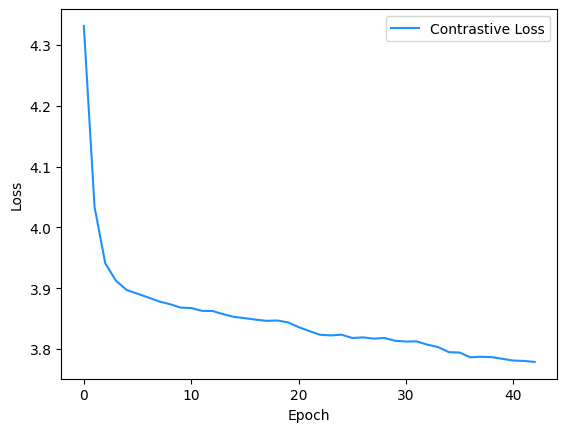

In [11]:
import matplotlib.pyplot as plt

plt.plot(range(43),train_loss_history, color = 'dodgerblue', label = 'Contrastive Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [8]:
device            = torch.device('cuda:0')

In [9]:
# 모델 정의
model = FTTransformer(categories=card_categories,
num_continuous=158,
dim=78,
depth=3,
heads=4,
dim_head=49,
num_special_tokens = 2,
attn_dropout=0.4585,
ff_dropout=0.4210).to(device)

In [10]:
checkpoint = torch.load("Contrastive_Embedding_Net_ftt(0203-45epoch).pt")
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>